2018 Edition

# Building a music recommender system

As its name implies, a recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.

## Goals

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm (serial and parallel versions)

- Build a simple model for a real usecase: music recommender system

- Understand how to validate the results

## Steps

We assume students to work outside lab hours on the learning material. These are the steps by which we guide students, during labs, to build a good basis for the end-to-end development of a recommender system:

* Inspect the data using Spark SQL, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing a (parallel) algorithm
* Finally, we will focus on an existing implementation, available in the Apache Spark MLLib, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.


# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for “scrobbling”, or recording listeners’ plays of artists’ songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

### Reading material

- [Implicit Feedback for Inferring User Preference: A Bibliography](http://people.csail.mit.edu/teevan/work/publications/papers/sigir-forum03.pdf)
- [Comparing explicit and implicit feedback techniques for web retrieval: TREC-10 interactive track report](http://trec.nist.gov/pubs/trec10/papers/glasgow.pdf)
- [Probabilistic Models for Data Combination in Recommender Systems](http://mlg.eng.cam.ac.uk/pub/pdf/WilGha08.pdf)

The data we use in this Notebook is available in 3 files (these files are stored in our HDFS layer, in the directory  ```/datasets/lastfm```):

- **`user_artist_data.txt`**: It contains about 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users’ plays of artists’ are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|



## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

In [111]:
import os
import sys
import re
import random
import math
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import pandas as pd
import numpy as np
from time import time

sqlContext = SQLContext(sc)
base = "/datasets/lastfm/"

### Question 1

#### Question 1.0 (Non-grading)
<div class="alert alert-info">
Using SPARK SQL, load data from `/datasets/lastfm/user_artist_data.txt` and show the first 20 entries (via function `show()`).
</div>

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".

In [2]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema)

# we can cache a Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF.cache()

userArtistDF.show()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



#### Question 1.1: 
<div class="alert alert-info">
How many distinct users do we have in our data? 
</div>

In [59]:
uniqueUsers = userArtistDF.select('userID').distinct().count()
print("Total n. of users: ", uniqueUsers)

Total n. of users:  148111


#### Question 1.2
<div class="alert alert-info">
How many distinct artists do we have in our data ?
</div>

In [60]:
uniqueArtists = userArtistDF.select('artistID').distinct().count()
print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1631028


#### Question 1.3
<div class="alert alert-info">
One limitation of Spark MLlib's ALS implementation - which we will use later - is that it requires IDs for users and items to be nonnegative 32-bit integers. This means that IDs larger than `Integer.MAX_VALUE`, or `2147483647`, can't be used. So we need to check whether this data set conforms to the strict requirements of our library.  

What are the maximum and minimum values of column `userID` ?  
</div>

In [61]:
print("The 10 highest userID in descending order :")
userArtistDF.select('userID').distinct().orderBy(desc('userID')).show(10)

print("The 10 lowest userID in ascending order :")
userArtistDF.select('userID').distinct().orderBy(asc('userID')).show(10)

The 10 highest userID in descending order :
+-------+
| userID|
+-------+
|2443548|
|2443543|
|2443541|
|2443538|
|2443537|
|2443533|
|2443527|
|2443526|
|2443523|
|2443522|
+-------+
only showing top 10 rows

The 10 lowest userID in ascending order :
+------+
|userID|
+------+
|    90|
|    98|
|   116|
|   120|
|   128|
|   139|
|   277|
|   321|
|   340|
|   350|
+------+
only showing top 10 rows



As we can see, the user IDs are bounded by 90 and 2443548, which verifies the requirements :
$0 < 90 \leq userID \leq 2443548 < Integer.MAX$_$VALUE $

#### Question 1.4
<div class="alert alert-info">
What is the maximum and minimum values of column `artistID` ?
</div>

In [62]:
print("The 10 highest artistID in descending order :")
userArtistDF.select('artistID').distinct().orderBy(desc('artistID')).show(10)

print("The 10 lowest artistID in ascending order :")
userArtistDF.select('artistID').distinct().orderBy(asc('artistID')).show(10)

The 10 highest artistID in descending order :
+--------+
|artistID|
+--------+
|10794401|
|10794400|
|10794398|
|10794397|
|10794396|
|10794395|
|10794392|
|10794391|
|10794388|
|10794386|
+--------+
only showing top 10 rows

The 10 lowest artistID in ascending order :
+--------+
|artistID|
+--------+
|       1|
|       2|
|       3|
|       4|
|       5|
|       6|
|       7|
|       8|
|       9|
|      11|
+--------+
only showing top 10 rows



As we can see, the user IDs are bounded by 1 and 10794401, which verifies the requirements :
$0 < 1 \leq userID \leq 10794401 < Integer.MAX$_$VALUE $

We just discovered that we have a total of 148,111 users in our dataset. Similarly, we have a total of 1,631,028 artists in our dataset. The maximum values of `userID` and `artistID` are still smaller than the biggest number of integer type.  No additional transformation will be necessary to use these IDs.

One thing we can see here is that SPARK SQL provides very concise and powerful methods for data analytics (compared to using RDD and their low-level API). You can see more examples [here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html).

Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many times each user has played a song? This is a good indicator of who are the most active users of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play counts for each artist? This is a good indicator of the artist popularity. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

### Question 2

#### Question 2.1
<div class="alert alert-info">
How many times each user has played a song? Show 5 samples of the result.
</div>

In [3]:
# Compute user activity
# We are interested in how many playcounts each user has scored.
userActivity = userArtistDF.groupBy('userID').sum('playCount').collect()
print(userActivity[0:5])

[Row(userID=2129111, sum(playCount)=523), Row(userID=2130165, sum(playCount)=5), Row(userID=2133268, sum(playCount)=1135), Row(userID=2134210, sum(playCount)=558), Row(userID=2134480, sum(playCount)=1702)]


Here we collect the dataframe, because we want to reuse it in the next question, without computing it again. The collect function can be used because the dataframe fits in the driver. In the case where it does not, we should try to cache the result first instead of collecting it to the driver.

#### Question 2.2
<div class="alert alert-info">
Plot CDF (or ECDF) of the number of play counts per User ID.  

Explain and comment the figure you just created:   
<ul>
<li>for example, look at important percentiles (25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible. </li>
<li>discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system. </li>
<li>look at outliers and reason about their impact on your reccommender algorithm</li>
</ul>
</div>

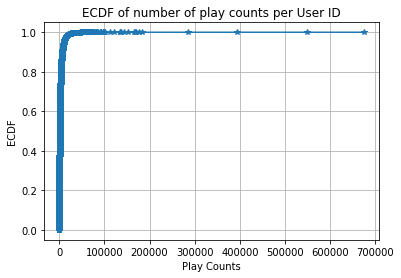

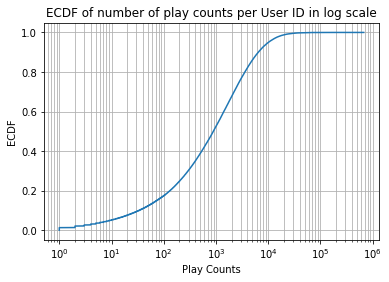

In [4]:
pdfUserActivity = pd.DataFrame(data=userActivity, columns = ['userID', 'playCount'])

Y=np.sort( pdfUserActivity['playCount'] )

yvals=np.arange(len(Y))/float(len(Y))

plt.plot( Y, yvals,'-*' )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID')
plt.show()


plt.semilogx(Y, yvals)
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID in log scale')
plt.show()

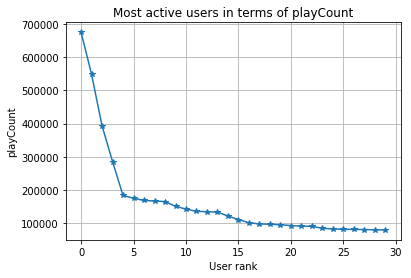

Total number of playCount: 371638969
Proportion of plays by the 4 outliers: 0.5118763527728977 %

Quantile of users IDs in terms of play counts:


,playCount
0.05,10.0
0.10,34.0
0.25,204.0
0.50,892.0
0.75,2800.0
0.90,6484.0
0.95,10120.0


In [5]:
pdfUserActivitySorted = pdfUserActivity.sort_values(by='playCount', ascending=False)
plt.plot(range(30),pdfUserActivitySorted['playCount'][0:30],'-*')
plt.xlabel('User rank')
plt.ylabel('playCount')
plt.grid(True,which="both",ls="-")
plt.title('Most active users in terms of playCount')
plt.show()

nbTotalPlay = pdfUserActivitySorted['playCount'].sum()
print("Total number of playCount:",nbTotalPlay)

print("Proportion of plays by the 4 outliers:",pdfUserActivitySorted['playCount'][0:4].sum()/nbTotalPlay*100,"%")

print("\nQuantile of users IDs in terms of play counts:")
pdfUserActivitySorted[['playCount']].quantile(q=[0.05,0.1,0.25,0.5,0.75,0.90,0.95], axis=0)

* The y-axis represents the cumulative proportion of users. The curve shows the proportion of users that have listened less songs than the corresponding number of playCount. To increase readability of values, we plotted the curve in a log scale. For example : we can see that 50 percents of users have listened less than approximately 900 songs. Indeed, when calculating the percentiles, we found that the median of playCount is 892 playCount.
* The curve also reveals outliers. Indeed, four users seem to be way more active than the majority. To outline this, we plotted the top 10 most active users which confirms our deduction. There is a clear elbow in the curve that seperates the outliers. They represent more than 0.5% of the total number of playcounts among the 148 thousands users.
* Moreover, the percentile shows that 10% of users have played a song at most 34 times and 5% have played less than 10 times a song. We have less information about their taste, but it's important to suggest recommendation to least active users, encouraging them to listen more on the platform. It's among those users that the improvement of the recommander system can make a significant difference.

#### Question 2.3

<div class="alert alert-info">
How many play counts for each artist? Plot CDF or ECDF of the result.  

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?
</div>

In [6]:
# Compute artist popularity
# We are interested in how many playcounts per artist
# ATTENTION! Grouping by artistID may be problematic, as stated above.

artistPopularity = userArtistDF.groupBy('artistID').sum('playCount').collect()
print(artistPopularity[0:5])

[Row(artistID=1003514, sum(playCount)=949), Row(artistID=1004346, sum(playCount)=3772), Row(artistID=5409, sum(playCount)=526693), Row(artistID=1002519, sum(playCount)=405), Row(artistID=1004223, sum(playCount)=409)]


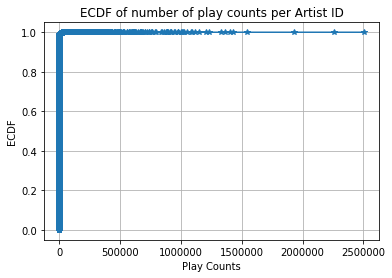

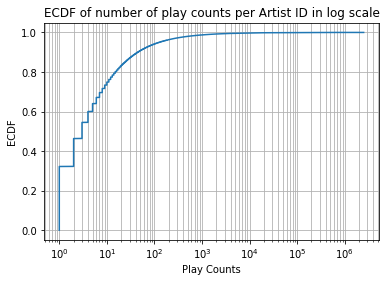

In [7]:
pdfArtistPopularity = pd.DataFrame(data=artistPopularity, columns = ['artistID', 'playCount'])

Y=np.sort( pdfArtistPopularity['playCount'] )

yvals=np.arange(len(Y))/float(len(Y))

plt.plot( Y, yvals,'-*' )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per Artist ID')
plt.show()


plt.semilogx(Y, yvals)
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per Artist ID in log scale')
plt.show()

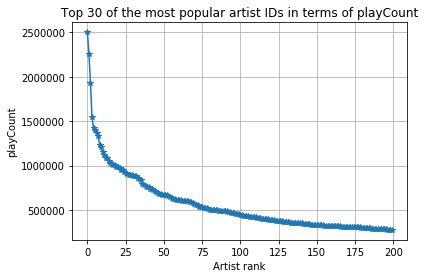

Total number of playCount: 371638969
Proportion of plays by the 3 outliers: 1.8006472835737524 %

Quantile for artist IDs in terms of play count:


,playCount
0.050,1.000
0.100,1.000
0.250,1.000
0.500,3.000
0.750,11.000
0.900,45.000
0.950,126.000
0.980,493.000
0.999,34624.892


In [8]:
pdfArtistPopularitySorted = pdfArtistPopularity.sort_values(by='playCount', ascending=False)
plt.plot(range(200),pdfArtistPopularitySorted['playCount'][0:200],'-*')
plt.xlabel('Artist rank')
plt.ylabel('playCount')
plt.grid(True,which="both",ls="-")
plt.title('Top 30 of the most popular artist IDs in terms of playCount')
plt.show()


print("Total number of playCount:",nbTotalPlay)

print("Proportion of plays by the 3 outliers:",pdfArtistPopularitySorted['playCount'][0:3].sum()/nbTotalPlay*100,"%")
print("\nQuantile for artist IDs in terms of play count:")
pdfArtistPopularitySorted[['playCount']].quantile(q=[0.05,0.1,0.25,0.5,0.75,0.90,0.95,0.98,0.999], axis=0)

* In the same fashion as the previous question, the two first figures show the ECDF of number of play counts per Artist ID. The x-axis is the play counts and the y-axis represents the proportion of artists with a lower total play count than indicated by the curve. Note that the we begin here to study the data without taking into account different IDs pointing at the same artist. 
* The figures seem here to indicate that the different plays are appart from outliers evenly spread out among IDs. Indeed, half of all artists Ids have less than 3 plays and 95% have less than 126 plays.
* Some outliers can again be found among artists. 3 artist IDs distinguish themselves from others with a far greater number of play counts. They represent more that 1.8 % of all plays.

#### Question 2.4
<div class="alert alert-info">
Plot a bar chart to show top 5 artists In terms of absolute play counts.  

Comment the figure you just obtained: 
<ul>
<li>are these reasonable results?</li>
<li>is looking at top-5 artists enough to learn more about your data?</li>
<li>do you see anything strange in the data?</li>
</ul>
</div>

In [9]:
def plotbarh(ypos,x,ylabels,xlabel='',ylabel='',title='',color='blue',alpha=0.4):
    """ Plot horizontal histogramm """
    plt.barh(y_pos, x, align='center', alpha=0.4,color=color)
    plt.yticks(y_pos, ylabels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    #plt.show()

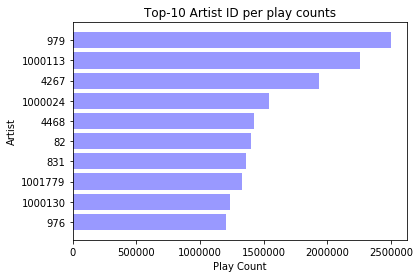

Total number of playCount: 371638969
Proportion of plays by the top 1.15% of all artist IDs: 90.05858828544969 %


In [10]:
sortedArtist = sorted(artistPopularity, key = lambda x: -x[1])[:10]

artistID = [w[0] for w in sortedArtist]

y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]
plotbarh(y_pos, frequency[::-1],artistID[::-1],'Play Count','Artist','Top-10 Artist ID per play counts')

plt.show()

print("Total number of playCount:",nbTotalPlay)
nbTotalArtist = len(pdfArtistPopularity)
propArtist = 0.0115
print("Proportion of plays by the top 1.15% of all artist IDs:",pdfArtistPopularitySorted['playCount'][0:math.floor(propArtist*nbTotalArtist)].sum()/nbTotalPlay*100,"%")

* As we previously observed, 3 artist IDs stand out from the rest. The top-10 artist IDs makes up for more than 4.3% of all plays. At first it seems quite low for popular artists.
* Looking at the top-5 or top-10 artist IDs is obviously not enough to fully understand the data. There is more than 1.6 million artists ID! It's impossible for example, to guess or predict that 50 % of all artist IDs have less than 3 playCounts if you simply look at the bar chart which is really strange. In more common terms it means that half of all artist IDs have seen one of their songs played at most three times across several years. It could be possible on a user-generated content platform (such as Youtube or other...), but LastFM doesn't offer this service to users. The data is clearly raw and needs to be processed. Only 1.12% of all artist IDs represents 90% of all playCounts. The utility matrix would be almost completly empty.


All seems clear right now, but ... wait a second! What about the problems indicated above about artist "disambiguation"? Are these artist ID we are using referring to unique artists? How can we make sure that such "opaque" identifiers point to different bands? Let's try to use some additional dataset to answer this question:  `artist_data.txt` dataset. This time, the schema of the dataset consists in:

```
artist ID: long int
name: string
```

We will try to find whether a single artist has two different IDs.

### Question 3

#### Question 3.1

<div class="alert alert-info">
Load the data from `/datasets/lastfm/artist_data.txt` and use the SparkSQL API to show 5 samples.  

<ul></ul>
<div class="label label-success">HINT:</div> If you encounter some error when parsing lines in data because of invalid entries, parameter `mode='DROPMALFORMED'` will help you to eliminate these entries. The suggested syntax is: `<df>.options(header='false', delimiter='\t', mode='DROPMALFORMED')`.

</div>

In [11]:
customSchemaArtist = StructType([ \
    StructField("artistID", LongType(), True), \
    StructField("name", StringType(), True)])

artistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load(base + "artist_data.txt", schema = customSchemaArtist)
    
# we can cache a Dataframe to avoid computing it from the beginning everytime it is accessed.
artistDF.cache()
    
artistDF.show(5)

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
| 1134999|        06Crazy Life|
| 6821360|        Pang Nakarin|
|10113088|Terfel, Bartoli- ...|
|10151459| The Flaming Sidebur|
| 6826647|   Bodenstandig 3000|
+--------+--------------------+
only showing top 5 rows



#### Question 3.2
<div class="alert alert-info">
Find 20 artists whose name contains `Aerosmith`. Take a look at artists that have ID equal to `1000010` and `2082323`. In your opinion, are they pointing to the same artist?  

<ul></ul>
<div class="label label-success">HINT:</div> Function `locate(sub_string, string)` can be useful in this case.
</div>

In [72]:
# get artists whose name contains "Aerosmith"
artistDF[locate("Aerosmith", artistDF.name) > 0].show(20)
print("Number of results:",artistDF[locate("Aerosmith", artistDF.name) > 0].count())

# show two examples
artistDF[artistDF.artistID==1000010].show()
artistDF[artistDF.artistID==2082323].show()

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
|10586006|Dusty Springfield...|
| 6946007|    Aerosmith/RunDMC|
|10475683|Aerosmith: Just P...|
| 1083031|    Aerosmith/ G n R|
| 6872848|Britney, Nsync, N...|
|10586963|Green Day - Oasis...|
|10028830|The Aerosmith Ant...|
|10300357| Run-DMC + Aerosmith|
| 2027746|Aerosmith by Musi...|
| 1140418|[rap]Run DMC and ...|
|10237208| Aerosmith + Run DMC|
|10588537|Aerosmith, Kid Ro...|
| 9934757|Aerosmith - Big Ones|
|10437510|Green Day ft. Oas...|
| 6936680| RUN DNC & Aerosmith|
|10479781|      Aerosmith Hits|
|10114147|Charlies Angels -...|
| 1262439|Kid Rock, Run DMC...|
| 7032554|Aerosmith & Run-D...|
|10033592|          Aerosmith?|
+--------+--------------------+
only showing top 20 rows

Number of results: 475
+--------+---------+
|artistID|     name|
+--------+---------+
| 1000010|Aerosmith|
+--------+---------+

+--------+------------+
|artistID|        name|
+--------+------------+
| 208

* We find about 500 artist Ids whose names contain "Aerosmith". It represents a lot of artist IDs and could explain the previous result: a lot of artist IDs with very few playcounts that actually represent the same artist.
* Moreover, in the list of names, we can note some 'ft.' in artist's names that can't be really considered as one artist ID, but as the cooperation of several artists. Some of them are for sure pointing to the same artist.
* Looking for Ids 1000010 and 2082323, the second ID seems to be a song whose name is Aerosmith, and could be the first song of an album published or not by Aerosmith. We therefore need a separate table to truly regroup the different IDs of the same artist.

To answer this question correctly, we need to use an additional dataset `artist_alias.txt` which contains the ids of mispelled artists and standard artists. The schema of the dataset consists in:

```
mispelledID ID: long int
standard ID: long int
```

#### Question 3.3
<div class="alert alert-info">
Using SparkSQL API, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.
</div>

In [12]:
customSchemaArtistAlias = StructType([ \
    StructField("mispelledID", LongType(), True), \
    StructField("standardID", LongType(), True)])

artistAliasDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load(base + "artist_alias.txt", schema = customSchemaArtistAlias)

# we can cache a Dataframe to avoid computing it from the beginning everytime it is accessed.
artistAliasDF.cache()
    
artistAliasDF.show(5)

+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
|    1092764|   1000311|
|    1095122|   1000557|
|    6708070|   1007267|
|   10088054|   1042317|
|    1195917|   1042317|
+-----------+----------+
only showing top 5 rows



#### Question 3.4
<div class="alert alert-info">
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.
</div>

In [74]:
print('The standard ID for mispelledID 1000010 and 2082323 are :')
artistAliasDF[artistAliasDF.mispelledID==1000010].show()
artistAliasDF[artistAliasDF.mispelledID==2082323].show()

print("20 examples of mispelledID that have a standardID equal to 1000010")
artistAliasDF[(artistAliasDF.mispelledID==1000010) | (artistAliasDF.standardID==1000010)].show()
print("Number of mispelledIDs for the standardID 1000010 : ", end='')
print(artistAliasDF[(artistAliasDF.mispelledID==1000010) | (artistAliasDF.standardID==1000010)].count())

# 1000010 is a standard id, so it hasn't been considered as mispelled id in the dataset

The standard ID for mispelledID 1000010 and 2082323 are :
+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
+-----------+----------+

+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
|    2082323|   1000010|
+-----------+----------+

20 examples of mispelledID that have a standardID equal to 1000010
+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
|    2082323|   1000010|
|    1019565|   1000010|
|    1053793|   1000010|
|    1128909|   1000010|
|    1174667|   1000010|
|    9899575|   1000010|
|    1104722|   1000010|
|    6796858|   1000010|
|    6784259|   1000010|
|    1227381|   1000010|
|    2027746|   1000010|
|    6845323|   1000010|
|    1059795|   1000010|
|    6617824|   1000010|
|    2015907|   1000010|
|    6630890|   1000010|
|    2046837|   1000010|
|    2048373|   1000010|
|    2070290|   1000010|
|    2035537|   1000010|
+-----------+----------+
only showing top 20 rows

Number of mispelledIDs

In [13]:
countMispelledId = pd.DataFrame(artistAliasDF.groupBy('standardID').count().orderBy(desc('count')).collect(), columns = ['standardID', 'count'])

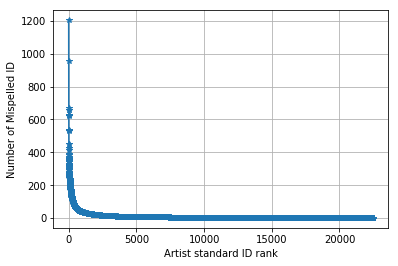

Number of misspelled ID: 193027
Number of standard ID: 22478


In [76]:
plt.plot(countMispelledId['count'],'-*')
plt.xlabel('Artist standard ID rank')
plt.ylabel('Number of Mispelled ID')
plt.grid(True,which="both",ls="-")
plt.show()
print("Number of misspelled ID:",countMispelledId['count'].sum() )
print("Number of standard ID:",len(countMispelledId['count']))

* The first empty table ensures that the id 1000010 is not considered as a mispelled id.
* The second table shows that indeed, the id 2082323 is considered a mispelled id of the previous id, which is a standard one.
* Finally, to go further, we looked for the different misspelled IDs of the standard ID 1000010. The 2082323 mispelled ID is still here, and we count in total 130 mispelled IDs for only one real artist.
* This can explain the previous results. The very unpopular artist ID could simply be mispelled artists name that no one looks for.

### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and re-compute the basic descriptive statistics on the "amended" data.
First, we construct a "dictionary" that maps non-standard ids to a standard ones. Then this "dictionary" will be used to replace the mispelled artists.

#### Question 4.1
<div class="alert alert-info">
From data in the dataframe loaded from `/datasets/lastfm/artist_alias.txt`, construct a dictionary that maps each non-standard id to its standard id.  

<div class="label label-success">HINT:</div> Instead of using function `collect`, we can use `collectAsMap` to convert the collected data to a dictionary inline.
</div>

In [14]:
artistAlias = artistAliasDF.rdd.map(lambda row: ( row[0] , row[1] )).collectAsMap()


#### Question 4.2
<div class="alert alert-info">
Using the constructed dictionary in question 4.1, replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.
</div>


**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.


Using funtion `map` on Spark Dataframe will give us an RDD. We can convert this RDD back to Dataframe by using `sqlContext.createDataFrame(rdd_name, sql_schema)`


**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem. 

In [15]:
from time import time

def replaceMispelledIDs(fields):
    finalID = artistAlias.get(fields[1],fields[1]) #If fields[1] is not in the dictionnary get returns the second argument which is also fields[1] considered standard if not found
    return (fields[0], finalID, fields[2])

t0 = time()
newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), #replace for each row the artistID with the corresponding ID in the dictionnary if any
    userArtistDataSchema #Same schema as initial schema, only values in cells change
)
t1 = time()

userArtistDF.show(5)
newUserArtistDF.show(5)
print('The script takes %f seconds' %(t1-t0))

#newUserArtistDF.cache()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 0.862002 seconds


In [79]:
print("Number of distinct artistId in the first table" ,userArtistDF.select("artistID").distinct().count())
print("Number of distinct artistId in the table where mispelledIds are removed",newUserArtistDF.select("artistID").distinct().count())

Number of distinct artistId in the first table 1631028
Number of distinct artistId in the table where mispelledIds are removed 1568126


In [80]:
newUserArtistDF.groupBy("userID","artistID").count().orderBy(desc("count")).show()

+-------+--------+-----+
| userID|artistID|count|
+-------+--------+-----+
|2133748| 1018110|   94|
|2052189| 1082784|   71|
|2360120|     122|   68|
|2302495| 1000024|   65|
|1053375| 1001819|   57|
|2214793| 1000130|   54|
|2181817|      82|   48|
|1000072| 1021625|   46|
|2197708| 1005386|   43|
|2117500| 1000881|   41|
|2054029| 1001419|   41|
|2360120|    1190|   40|
|2017825| 1003694|   38|
|2197701| 1002646|   33|
|2140727| 1026675|   33|
|2054029|    2439|   33|
|2205461|10316280|   32|
|1053335| 1000597|   32|
|2214793|    4481|   32|
|2205665| 1116582|   32|
+-------+--------+-----+
only showing top 20 rows



* It appears that the replacement was achieved. Indeed, the number of distinct artistIDs has decreased (from 1631028 to 1568126) by 3.8 %. It is confirmed by the number of duplicate pairs (userID, standardArtistID). For example: one user has listened to an artist through 94 distinct artistIDs.

#### Question 4.3
<div class="alert alert-info">
Spark actions are executed through a set of stages, separated by distributed "shuffle" operations. Spark can be instructed to **automatically and efficiently** broadcast common data needed by tasks within **each stage**. The data broadcasted this way is cached in **serialized form** and deserialized before running each task.   
<ul> </ul>
We can thus improve our answer to question 4.2: we can reduce the communication cost by shipping the "dictionary" in a more efficient way by using `broadcast variable`. Broadcast variables allow the programmer to keep a read-only variable cached on **each machine** rather than shipping a copy of it with tasks. They are cached in deserialized form. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner.   
<ul></ul>
The broadcast of variable `v` can be created by `bV = sc.broadcast(v)`. Then value of this broadcast variable can be access via `bV.value`  

<ul></ul>
To question is then: using a broadcast variable, modify the script in question 4.2 to get better performance in terms of running time.
</div>


In [16]:
from time import time

bArtistAlias = sc.broadcast(artistAlias)

def replaceMispelledIDs(fields):
    finalID = bArtistAlias.value.get(fields[1],fields[1]) #If fields[1] is not in the dictionnary get returns the second argument which is also fields[1] considered standard if not found
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)
t1 = time()
newUserArtistDF.show(5)


print('The script takes %f seconds' %(t1-t0))
newUserArtistDF = newUserArtistDF.cache()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 0.030193 seconds


Although having some advantages, explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries.

#### Question 5.1
<div class="alert alert-info">
How many unique artists? Compare with the result when using old data.
</div>

In [17]:
uniqueArtists = newUserArtistDF.select("artistID").distinct().count()

print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1568126


* As we have seen before, the number of distinct artistIDs was 1 631 028. In the new table where we have replaced the mispelled IDs by the standard ones, the number of distinct IDs is 1 568 126. The number has decreased because the mispelled artistIDs pointing to the same standard ID were all replaced.

#### Question 5.2

<div class="alert alert-info">
Who are the top-10 artistis?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "audience size", that is, how many users listened to one of their track at least once</li>
</ul>  

Plot the results, and explain the figures you obtain.
</div>

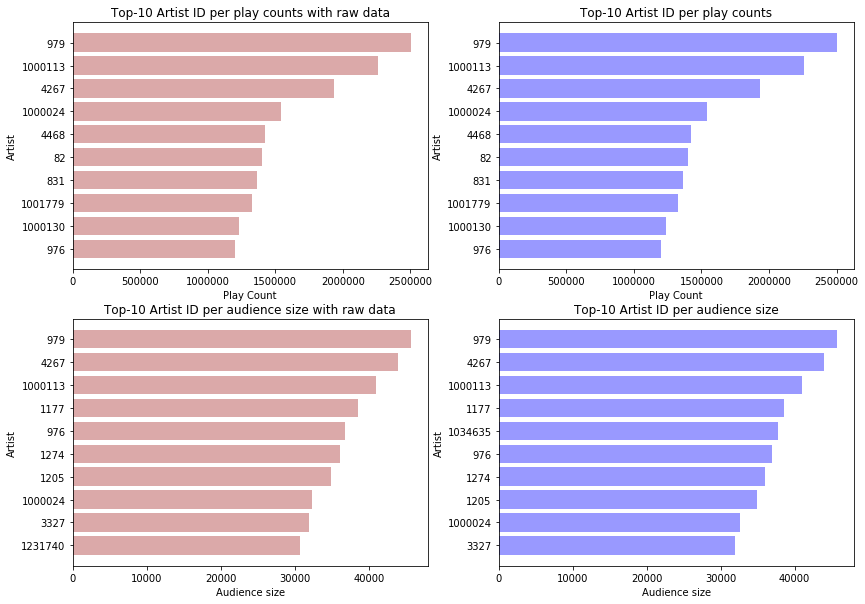

In [18]:
# calculate the old top-10 artists in term of play counts
top10OldArtistsPC = userArtistDF.groupBy( "artistID" ).sum( "playCount" ).orderBy('sum(playCount)', ascending=0).take(10)
y_pos = range(len(top10OldArtistsPC))
pdf = pd.DataFrame(data=top10OldArtistsPC)

plt.figure(figsize=(14,10))

plt.subplot(221)
plotbarh(y_pos,pdf[1][::-1],pdf[0][::-1],'Play Count','Artist','Top-10 Artist ID per play counts with raw data',color='brown')

# calculate the old top-10 artists in term of audience size
top10OldArtistsPC = userArtistDF.groupBy( "artistID" ).count().orderBy('count', ascending=0).take(10)
y_pos = range(len(top10OldArtistsPC))
pdf = pd.DataFrame(data=top10OldArtistsPC)

plt.subplot(223)
plotbarh(y_pos,pdf[1][::-1],pdf[0][::-1],'Audience size','Artist','Top-10 Artist ID per audience size with raw data',color="brown")


# calculate top-10 artists in term of play counts
top10ArtistsPC = newUserArtistDF.groupBy( "artistID" ).sum( "playCount" ).orderBy('sum(playCount)', ascending=0).take(10)
y_pos = range(len(top10ArtistsPC))
pdf = pd.DataFrame(data=top10ArtistsPC)

plt.subplot(222)
plotbarh(y_pos,pdf[1][::-1],pdf[0][::-1],'Play Count','Artist','Top-10 Artist ID per play counts',)

# calculate top-10 artists in term of audience size
top10ArtistsPC = newUserArtistDF.groupBy( "artistID" ).count().orderBy('count', ascending=0).take(10)
y_pos = range(len(top10ArtistsPC))
pdf = pd.DataFrame(data=top10ArtistsPC)

plt.subplot(224)
plotbarh(y_pos,pdf[1][::-1],pdf[0][::-1],'Audience size','Artist','Top-10 Artist ID per audience size')

plt.show()

In [19]:
print("Number of mispelledIDs for the standard one:")
countMispelledId[countMispelledId.standardID == 1231740]

Number of mispelledIDs for the standard one:


,standardID,count
379,1231740,82


* At first, the comparison with the previous plots with raw data shows there is no order difference in the top-10 per playCounts. 
* In terms of audience size, the order changes slightly. Even thought it is standard, the ID 1231740 disapeared from the raw top-10.

In [20]:
print("Top-10 of standard IDs in terms of mispelled:")
countMispelledId[0:10]

Top-10 of standard IDs in terms of mispelled:


,standardID,count
0,1000024,1204
1,1034635,955
2,82,671
3,1003694,656
4,1854,656
5,1000113,629
6,930,628
7,979,620
8,1000107,537
9,976,536


* To further investigate the top-10, we can refer to the top-10 in terms of mispelled.
* 6 out of the 10 IDs with the most mispelled belongs to one of the top-10s above. There seems to be a link between the popularity of a given artist and his number of mispelledID.
* More significantly, we can see that the artist 1034635 belongs to the new top-10 and not in the old one. He is one the 2 outliers in terms of mispelled ID with 955 mispelled ID, which indicates that its play counts were spread among the mispelled IDs.

* This analysis proves that raw data can lead to a misunderstanding of the data true nature. A simple recommendation system based on the top-10 most popular artists would have probably missed the artist 1034635, the 5th most popular artist in terms of audience size.

* In order to complement this analysis let's redo the statistic analysis on the cumulated distribution.

In [21]:
# Compute NEW artist popularity
# We are interested in how many playcounts per artist

newArtistPopularity = newUserArtistDF.groupBy('artistID').sum('playCount').collect()

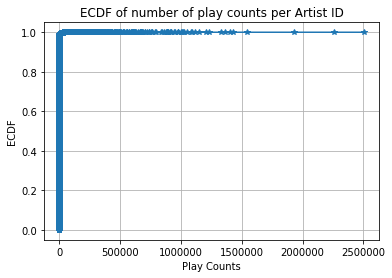

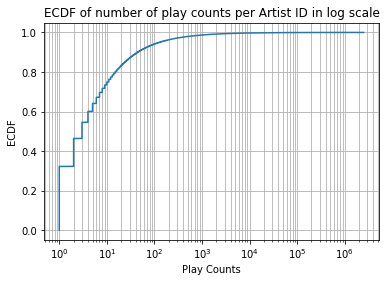

In [22]:
pdfNewArtistPopularity = pd.DataFrame(data=newArtistPopularity, columns = ['artistID', 'playCount'])

Y=np.sort( pdfNewArtistPopularity['playCount'] )

yvals=np.arange(len(Y))/float(len(Y))

plt.plot( Y, yvals,'-*' )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per Artist ID')
plt.show()

plt.semilogx(Y, yvals)
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per Artist ID in log scale')
plt.show()

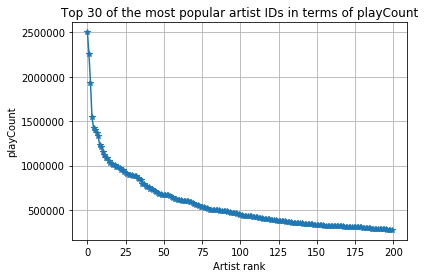

Total number of playCount: 371638969
Proportion of plays by the 3 outliers: 1.801093146397142 %


In [23]:
pdfNewArtistPopularitySorted = pdfNewArtistPopularity.sort_values(by='playCount', ascending=False)
plt.plot(range(200),pdfNewArtistPopularitySorted['playCount'][0:200],'-*')
plt.xlabel('Artist rank')
plt.ylabel('playCount')
plt.grid(True,which="both",ls="-")
plt.title('Top 30 of the most popular artist IDs in terms of playCount')
plt.show()

print("Total number of playCount:",nbTotalPlay)

print("Proportion of plays by the 3 outliers:",pdfNewArtistPopularitySorted['playCount'][0:3].sum()/nbTotalPlay*100,"%")

In [24]:
print("Quantiles with unprocessed artistIDs previously computed:")
pdfArtistPopularitySorted[['playCount']].quantile(q=[0.05,0.1,0.25,0.5,0.75,0.90,0.95,0.98,0.999], axis=0)

Quantiles with unprocessed artistIDs previously computed:


,playCount
0.050,1.000
0.100,1.000
0.250,1.000
0.500,3.000
0.750,11.000
0.900,45.000
0.950,126.000
0.980,493.000
0.999,34624.892


In [25]:
print("Quantiles with mispelled artistIDs fixed:")
pdfNewArtistPopularitySorted[['playCount']].quantile(q=[0.05,0.1,0.25,0.5,0.75,0.90,0.95,0.98,0.999], axis=0)

Quantiles with mispelled artistIDs fixed:


,playCount
0.050,1.000
0.100,1.000
0.250,1.000
0.500,3.000
0.750,11.000
0.900,45.000
0.950,128.000
0.980,516.000
0.999,36237.375


* First, the cumulated distribution curves seem quite similar. The quantile will help highlight the impact.
* The quantile, indeed, outlines the same effect as we observed with the top 10. The majority of artists have still very low play counts. However, the impact grows with the play counts.

#### Question 5.3

<div class="alert alert-info">
Who are the top-10 users?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "curiosity", that is, how many different artists they listened to</li>

</ul>  

Plot the results
</div>

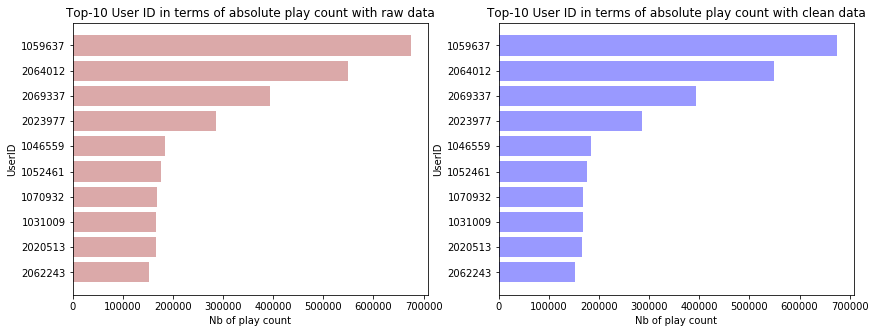

In [26]:
plt.figure(figsize=(14,5))

# calculate the old top-10 users in term of curiosity
top10OldUsersByPC = userArtistDF.groupBy( "userID" ).sum("playCount").orderBy('sum(playCount)', ascending=0).take(10)
y_pos = range(len(top10OldUsersByPC))
pdfOld = pd.DataFrame(data=top10OldUsersByPC)

plt.subplot(121)
plotbarh(y_pos,pdfOld[1][::-1],pdfOld[0][::-1],'Nb of play count','UserID','Top-10 User ID in terms of absolute play count with raw data',color="brown")

# calculate top-10 users in term of curiosity
top10UsersByPC = newUserArtistDF.groupBy( "userID" ).sum("playCount").orderBy('sum(playCount)', ascending=0).take(10)
y_pos = range(len(top10UsersByPC))
pdfNew = pd.DataFrame(data=top10UsersByPC)

plt.subplot(122)
plotbarh(y_pos,pdfNew[1][::-1],pdfNew[0][::-1],'Nb of play count','UserID','Top-10 User ID in terms of absolute play count with clean data')

plt.show()

* As expected, the cleaning of the data has no impact on the play counts per users.

In [27]:
dfOldUserCuriosity = userArtistDF.select("userID","artistID").distinct().groupBy("userID").count()
dfNewUserCuriosity = newUserArtistDF.select("userID","artistID").distinct().groupBy("userID").count()

pdfOldUserCuriosity =  pd.DataFrame(data=dfOldUserCuriosity.collect(),columns = ['userID','curiosity'])
pdfNewUserCuriosity = pd.DataFrame(data=dfNewUserCuriosity.collect(),columns = ['userID','curiosity'])

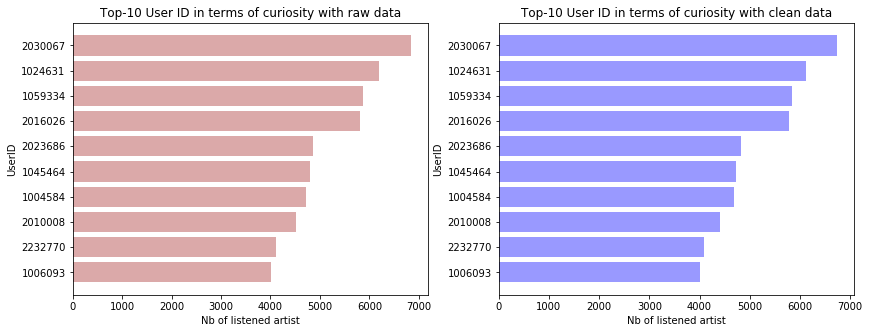

Difference in terms of artists listened:
 9    -14
8    -25
7   -101
6    -19
5    -62
4    -41
3    -33
2    -25
1    -63
0   -101
Name: 1, dtype: int64


In [28]:
plt.figure(figsize=(14,5))

# calculate the old top-10 users in term of curiosity
top10OldUsersByCuriosity = dfOldUserCuriosity.orderBy('count', ascending=0).take(10)
y_pos = range(len(top10OldUsersByCuriosity))
pdfOld = pd.DataFrame(data=top10OldUsersByCuriosity)

plt.subplot(121)
plotbarh(y_pos,pdfOld[1][::-1],pdfOld[0][::-1],'Nb of listened artist','UserID','Top-10 User ID in terms of curiosity with raw data',color="brown")

# calculate top-10 users in term of curiosity
top10UsersByCuriosity = dfNewUserCuriosity.orderBy('count', ascending=0).take(10)
y_pos = range(len(top10UsersByCuriosity))
pdfNew = pd.DataFrame(data=top10UsersByCuriosity)

plt.subplot(122)
plotbarh(y_pos,pdfNew[1][::-1],pdfNew[0][::-1],'Nb of listened artist','UserID','Top-10 User ID in terms of curiosity with clean data')
plt.show()

print('Difference in terms of artists listened:\n',pdfNew[1][::-1]-pdfOld[1][::-1])


In [29]:
pdfOldUserCuriosity[['curiosity']].quantile(q=[0.05,0.1,0.25,0.5,0.75,0.90,0.95,0.98,0.999], axis=0)

,curiosity
0.050,3.00
0.100,9.00
0.250,35.00
0.500,97.00
0.750,212.00
0.900,389.00
0.950,544.00
0.980,784.00
0.999,2060.34


In [30]:
pdfNewUserCuriosity[['curiosity']].quantile(q=[0.05,0.1,0.25,0.5,0.75,0.90,0.95,0.98,0.999], axis=0)

,curiosity
0.050,3.00
0.100,9.00
0.250,34.00
0.500,96.00
0.750,210.00
0.900,386.00
0.950,540.00
0.980,778.00
0.999,2031.89


* First, the most curious users listen to more than 4000 artists. The most curious of all listens to almost 7000 artists.
* Unlike the absolute playCount, the cleaning of the data has as expected an impact on the curiosity. Some artists that had different distinct IDs are now grouped under the same standard ID. The curiosity of users has therefore decreased. It can be seen distinctly with the quantile information. And logically, the impact increases with the curiosity of the users. The more a user listens to a lot of artists, the more chances he has to listen to mispelled artists.
* The median curiosity of users is to listen about 100 different artists.

# Conclusion


* Through this process of cleaning the data, we have learnt a lot about the data:
 * Even after fixing mispelled artists, a majority of artists are not widely listened to.
 * A small fraction of all artists accounts for most play counts.
 * A significant portion of users are not very curious and active.
 * A small fraction of users are extremely curious.

* However we haven't taken into account potential invalid entries in the cleaning process.

Now we have some valuable information about the data. It's the time to study how to build a statistical models.

# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| | IT1 | IT2 | IT3 | ... | ITk |
|---|---|---|---|---|---|
| U1 | 1 |  | 5 | ... | 3 |
| U2 |  | 2 |  | ... | 2 |
| U3 | 5 |  | 3 | ... |  |
| U4 | 3 | 3 |  | ... | 4 |
| U5 |  | 1 |  | ... | ... |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the similarity of items `IT2` and `IT3`, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that the people who rated both `IT2` and `IT3` tended to give them similar ratings. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems focus on properties of items. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the relationship between users and items. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in terms of tastes for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

### 2.3.1 Basic idea and an example of Matrix Factorization
For example, given a preference matrix 5x5 as below, we want to approximate this matrix into the product of two smaller matrixes $X$ and $Y$ .

$$
M = 
\begin{bmatrix}
 5 & 2 & 4 & 4 & 3 \\
 3 & 1 & 2 & 4 & 1 \\
 2 &  & 3 & 1 & 4 \\
 2 & 5 & 4 & 3 & 5 \\
 4 & 4 & 5 & 4 &  \\
\end{bmatrix}
\approx M^\prime =
\begin{bmatrix}
 x_{11} & x_{12} \\
 x_{21} & x_{22} \\
 x_{31} & x_{32} \\
 x_{41} & x_{42} \\
 x_{51} & x_{52} \\
\end{bmatrix}
\times
\begin{bmatrix}
 y_{11} & y_{12} & y_{13} & y_{14} & y_{15} \\
 y_{21} & y_{22} & y_{23} & y_{24} & y_{25} \\
\end{bmatrix}
$$

$M^\prime$ is an approximation that is as close to A as possible. To calculate how far from $M$ $M^\prime$ is, we often calculate the sum of squared distances of non-empty elements in $M$ and the corresponding elements in $M^\prime$.
In this way, for $M^\prime$, besides the approximated elements in $M$, we also have the non-observed elements. Therefore, to see how much does user `i` like item `j`, we simply pick up the value of $M^\prime_{i,j}$.

The challenge is how to calculate $X$ and $Y$. The bad news is that this can't be solved directly for both the best $X$ and best $Y$ at the same time. Fortunately, if $Y$ is known, we can calculate the best of $X$, and vice versa. It means from the initial values of $X$ and $Y$ in the beginning, we calculate the best $X$ according to $Y$, and then calculate the best $Y$ according to the new $X$. This process is repeated until the distance from $XY$ to $M$ is small. It's simple, right ?

Let's take an example. To compute the approximation for the above 5x5 matrix $M$, first, we initialize the value of $X$ and $Y$ as below.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

With the initial iteration, we calculate the the Root-Mean-Square Error from $XY$ to $M$.

Consider the ﬁrst rows of $M$ and $XY$ . We subtract the first row of $XY$ from the entries in the ﬁrst row of $M$, to get $3,0,2,2,1$. We square and sum these to get $18$. 

In the second row, we do the same to get $1,−1,0,2,−1$, square and sum to get $7$. 

In the third row, the second column is blank, so that entry is ignored when computing the RMSE. The diﬀerences are $0,1,−1,2$ and the sum of squares is $6$. 

For the fourth row, the diﬀerences are $0,3,2,1,3$ and the sum of squares is $23$. 

The ﬁfth row has a blank entry in the last column, so the diﬀerences are $2,2,3,2$ and the sum of squares is $21$. 

When we sum the sums from each of the ﬁve rows, we get $18+7+6+23+21 = 75$. So, $RMSE=\sqrt{75/23}=1.806$ where $23$ is the number of non-empty values in $M$.

Next, with the given value of $Y$, we calculate $X$ by finding the best value for $X_{11}$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 x & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 x+1 & x+1 & x+1 & x+1 & x+1 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

Now, to minimize the $RMSE$  we minimize the difference of the first rows $(5−(x+1))^2 + (2−(x+1))^2 + (4−(x+1))^2 + (4−(x+1))^2 + (3−(x+1))^2$. By  taking the derivative and set that equal to 0, we pick $x=2.6$

Given the new value of $X$, we can calculate the best value for $Y$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 2.6 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 y & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 3.6 & 3.6 & 3.6 & 3.6 & 3.6 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

By doing the same process as before, we can pick value for $y=1.617$. After that, we can check if the $RMSE$ is not converged, we continue to update $X$ by $Y$ and vice versa. In this example, for simple, we only update one element of each matrix in each iteration. In practice, we can update a full row or full matrix at once.


### 2.3.2 Matrix Factorization: Objective and ALS Algorithm on a Single Machine

More formally, in general, we select $k$ latent features, and describe each user $u$ with a $k-$dimensional vector $x_u$, and each item $i$ with a $k-$dimensional vector $y_i$.

Then, to predict user $u$'s rating for item $i$, we do as follows: $ r_{ui} \approx x_{u}^{T}y_i$.

This can be put, more elegantly, in a matrix form. Let $x_1, \cdots x_n \in \mathbb{R}^k$ be the factors for the users, and $y_1, \cdots y_m \in \mathbb{R}^k$ the factors for the items. The $k \times n$ user matrix $X$ and the $k \times m$ item matrix $Y$ are then defined by:

$$
X = 
\begin{bmatrix}
 |   &         & |  \\
x_1  &  \cdots & x_n\\
 |   &         & |  \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
 |   &         & |  \\
y_1  &  \cdots & y_i\\
 |   &         & |  \\
\end{bmatrix}
$$

Our goal is to estimate the complete ratings matrix $R \approx X^{T} Y$. We can formulate this problem as an optimization problem in which we aim to minimize an objective function and find optimal $X$ and $Y$ . In particular, we aim to minimize the least squares error of the observed ratings (and regularize):

$$
\min_{X,Y} \sum_{r_{ui} \text{observed}}(r_{ui} - x_{u}^{T}y_i)^2 + \lambda \left( \sum_{u} \|x_u\|^2 + \sum_{i} \|y_i\|^2 \right) 
$$

Notice that this objective is non-convex (because of the $x_{u}^{T} y_i$ term); in fact it’s NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables $X$ and treat them as constants, then the objective is a convex function of $Y$ and vice versa. Our approach will therefore be to fix $Y$ and optimize $X$, then fix $X$ and optimize $Y$, and repeat until convergence. This approach is known as **ALS (Alternating Least Squares)**. For our objective function, the alternating least squares algorithm can be expressed with this simple pseudo-code:


**Initialize** $X$, $Y$

**while(convergence is not true) do**


**for** $u = 1 \cdots n$ **do**

$x_u = \left( \sum_{r_{ui} \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 
   
**end for**

**for** $u = 1 \cdots n$ **do**

$y_i = \left( \sum_{r_ui \in r_{*i}} x_u x_{u}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{*i}} r_{ui} x_u $ 
   
**end for**


**end while**


For a single machine, we can analyze the computational cost of this algorithm. Updating each $x_u$ will cost $O(n_u k^2 + k^3)$, where $n_u$ is the number of items rated by user $u$, and similarly updating each $y_i$ will cost $O(n_i k^2 + k^3)$, where $n_i$ is the number of users that have rated item $i$.


Once we’ve computed the matrices $X$ and $Y$, there are several ways compute a prediction. The first is to do what was discussed before, which is to simply predict $ r_{ui} \approx x_{u}^{T}y_i$ for each user $u$ and item $i$. 
This approach will cost $O(nmk)$ if we’d like to estimate every user-item pair. 

However, this approach is prohibitively expensive for most real-world datasets. A second (and more holistic) approach is to use the $x_u$ and $y_i$ as features in another learning algorithm, incorporating these features with others that are relevant to the prediction task.

### 2.3.3 Parallel Altenating Least Squares

There are several ways to distribute the computation of the ALS algorithm depending on how data is partitioned.

#### Method 1: using joins
First we consider a fully distributed version, in the sense that all data (both input and output) is stored in a distributed file system. In practice, input data (ratings) and parameters ($X$ and $Y$) are stored in an a Spark RDD. Specifically, ratings -- that are always **sparse** -- are stored as RDD of triplets:

Ratings: RDD((u, i, $r_{ui}$), . . . )


Instead, we can use dense representation for factor matrices $X$ and $Y$, and these are stored as RDDs of vectors. More precisely, we can use the data types introduced in Spark MLLib to store such vectors and matrices:

X : RDD($x_1$,...,$x_n$)

Y : RDD($y_1$,...,$y_m$)


Now, recall the expression to compute $x_u$:

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 

Let's call the first summation *part A* and the second summation *part B*. To compute such parts, in parallel, we can proceed with the following high-level pseudocode:

* Join the Ratings RDD with the $Y$ matrix RDD using key $i$ (items)
* Map to compute $y_i y_{i}^{T}$ and emit using key $u$ (user)
* ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} y_i y_{i}^{T}$
* Invert
* Another ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} r_{ui} y_i$

We can use the same template to copmute $y_i$.

This approach works fine, but note it requires computing $y_i y_{i}^{T}$ for each user that has rated item $i$. 

#### Method 2: using broadcast variables (advanced topic)
The next approach takes advantage of the fact that the $X$ and $Y$ factor matrices are often very small and can be stored locally on each machine.

* Partition the Ratings RDD **by user** to create $R_1$, and similarly partition the Ratings RDD **by item** to create $R_2$. This means there are two copies of the same Ratings RDD, albeit with different partitionings. In $R_1$, all ratings by the same user are on the same machine, and in $R_2$ all ratings for same item are on the same machine.
* Broadcast the matrices $X$ and $Y$. Note that these matrices are not RDD of vectors: they are now "local: matrices.
* Using $R_1$ and $Y$, we can use expression $x_u$ from above to compute the update of $x_u$ locally on each machine
* Using $R_2$ and $X$, we can use expression $y_i$ from above to compute the update of $y_i$ locally on each machine

A further optimization to this method is to group the $X$ and $Y$ factors matrices into blocks (user blocks and item blocks) and reduce the communication by only sending to each machine the block of users (or items) that are needed to compute the updates at that machine. 

This method is called **Block ALS**. It is achieved by precomputing some information about the ratings matrix to determine the "out-links" of each user (which blocks of the items it will contribute to) and "in-link" information for each item (which of the factor vectors it receives from each user block it will depend on). For exmple, assume that machine 1 is responsible for users 1,2,...,37: these will be block 1 of users. The items rated by these users are block 1 of items. Only the factors of block 1 of users and block 1 of items will be broadcasted to machine 1.

### Further readings
Other methods for matrix factorization include:

* Low Rank Approximation and Regression in Input Sparsity Time, by Kenneth L. Clarkson, David P. Woodruff. http://arxiv.org/abs/1207.6365
* Generalized Low Rank Models (GLRM), by Madeleine Udell, Corinne Horn, Reza Zadeh, Stephen Boyd. http://arxiv.org/abs/1410.0342
* Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares, by Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh . Statistics Department and ICME, Stanford University, 2014. http://stanford.edu/~rezab/papers/fastals.pdf

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly. So, an algorithm which can run on a distributed system (SPARK, Hadoop...) is very suitable.

From these requirement, we can choose using ALS algorithm in SPARK's MLLIB.

Spark MLlib’s ALS implementation draws on ideas from [1](http://yifanhu.net/PUB/cf.pdf) and [2](http://link.springer.com/chapter/10.1007%2F978-3-540-68880-8_32).

## 3.2 Notes

Currently, MLLIB can only build models from an RDD. That means we have two ways to prepare data:

* Loading to into SPARK SQL DataFrame as before, and then access the corresponding RDD by calling `<dataframe>.rdd`. The invalid data is often sucessfully dropped by using mode `DROPMALFORMED`. However, this way might not work in all cases. Fortunately, we can use it with this usecase.

* Loading data directly to RDD. However, we have to deal with the invalid data ourself. In the trade-off, this way is the most reliable, and can work in every case.

In this notebook, we will use the second approach: it requires a bit more effort, but the reward is worth it!

 
## 3.3 Cleanup the data
In section 1, we already replaced the ids of mispelled artists by the corresponding standard ids by using SPARK SQL API.
However, if the data has the invalid entries such that SPARK SQL API is stuck, the best way to work with it is using an RDD.

Just as a recall, we work with three datasets in `user_artist_data.txt`, `` and `artist_alias.txt`. The entries in these file can be empty or have only one field. 

In details our goal now is:

* Read the input ```user_artist_data.txt``` and transforms its representation into an output dataset.
* To produce an output "tuple" containing the original user identifier and play counts, but with the artist identifier replaced by its most common alias, as found in the ```artist_alias.txt``` dataset.
* Since the ```artist_alias.txt``` file is small, we can use a technique called **broadcast variables** to make such transformation more efficient.


### Question 6

#### Question 6.1

<div class="alert alert-info">
Load data from `/datasets/lastfm/artist_alias.txt` and filter out the invalid entries to construct a dictionary to map from mispelled artists' ids to standard ids.
</div>

NOTE: From now on, we will use the "standard" data to train our model.

HINT: If a line contains less than 2 fields or contains invalid numerial values, we can return a special tuple. After that, we can filter out these special tuples.

In [31]:
#In a different cell to seperate function definition and other operations
def xtractFields(s):
    # Using white space or tab character as separetors,
    # split a line into list of strings 
    line = re.split("\s|\t",s,1)
    # if this line has at least 2 characters
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1)

In [32]:
rawArtistAlias = sc.textFile(base + "artist_alias.txt")

artistAlias = (
                rawArtistAlias
                    # extract fields using function xtractFields
                    .map( xtractFields )
    
                    # filter out the special tuples
                    .filter( lambda row: row[0]!=-1 and row[1]!=-1 )
    
                    # collect result to the driver as a "dictionary"
                    .collectAsMap()
                )

In [33]:
print("Initial number of pairs:",rawArtistAlias.count())
print("Filtered number of pairs:",len(artistAlias))

Initial number of pairs: 193027
Filtered number of pairs: 190892


* By using the filter function, more than 2100 unvalid fields were filtered.

#### Question 6.2
<div class="alert alert-info">
Using the dictionary in question 6.1, prepare RDD `userArtistDataRDD` by replacing mispelled artists' ids to standard ids. Show 5 samples.
</div>

HINT: Using broadcast variable can help us increase the efficiency.

In [34]:
bArtistAlias = sc.broadcast(artistAlias)
rawUserArtistData = sc.textFile(base + "user_artist_data.txt")

def disambiguate(line):
    [userID, artistID, count] = line.split(' ')
    finalArtistID = bArtistAlias.value.get(artistID,artistID)
    return (userID, finalArtistID, count)

userArtistDataRDD = rawUserArtistData.map(disambiguate)
dfNew = sqlContext.createDataFrame(userArtistDataRDD,["userID","artistID","playCount"])
userArtistDataRDD.take(5)

[('1000002', '1', '55'),
 ('1000002', '1000006', '33'),
 ('1000002', '1000007', '8'),
 ('1000002', '1000009', '144'),
 ('1000002', '1000010', '314')]

In [35]:
#To make sure the replacement has taken place the way we want, let's see how many of mispelledID is left 
newArtistIDs= dfNew.select("artistID").distinct().rdd.collect()
cumulatedNumberMispelled=0
for newArtistID in newArtistIDs:
    try:
        cumulatedNumberMispelled+=artistAlias[newArtistID[0]] #We add directly the ID if in the dictionnary
    except:
        pass

In [36]:
print('Number of mispelled artist ID in the clean RDD:',cumulatedNumberMispelled)

Number of mispelled artist ID in the clean RDD: 0


## 3.4 Training our statistical model
To train a model using ALS, we must use a preference matrix  as an input. MLLIB uses the class `Rating` to support the construction of a distributed preference matrix.

### Question 7

#### Question 7.1
<div class="alert alert-info">
Given RDD `userArtistDataRDD` in question 6.2, construct a new RDD `trainingData` by tranforming each item of it into a `Rating` object.
</div>

In [37]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [38]:
# after replacing mispelled artist ids, the data contains some play count duplications of a user with the same artist
# remember to aggregate these records
allData =userArtistDataRDD.map(lambda row: ((row[0], row[1]),row[2])) \
                            .reduceByKey(lambda x,y: x+y) \
                            .map(lambda r: Rating(r[0][0], r[0][1], r[1])) \
                            .repartition(4).cache()

* First, to aggregate the play counts of identical pairs, we use the shuffle and sort on the complex key (userID,ArtistID)
* The key being the couple, we simply aggregate the play counts hence the reduceByKey
* Finally, we transform each unique pair into a Rating object
* And Cache will help processing time

5 Samples of the brand new RDD:

In [39]:
allData.take(5)

[Rating(user=1001156, product=1003652, rating=4.0),
 Rating(user=1001156, product=7008630, rating=1.0),
 Rating(user=1001174, product=5860, rating=3.0),
 Rating(user=1001192, product=1259455, rating=3.0),
 Rating(user=1001214, product=1006322, rating=57.0)]

#### Question 7.2
<div class="alert alert-info">
A model can be trained by using `ALS.trainImplicit(<training data>, <rank>)`, where:
<ul>
<li>`training data` is the input data you decide to feed to the ALS algorithm</li>
<li>`rank` is the number of laten features</li>
</ul>  


We can also use some additional parameters to adjust the quality of the model. Currently, let's set 
<ul>
<li>`rank=10`</li>
<li>`iterations=5`</li>
<li>`lambda_=0.01`</li>
<li>`alpha=1.0` </li>
</ul>
to build model.
</div>

In [40]:
t0 = time()
model = ALS.trainImplicit(allData, rank=10, iterations=5, lambda_=0.01, alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 56.280268 secs


* Training the model takes a lot of time.

#### Question 7.3
<div class="alert alert-info">
The trained model can be saved into HDFS for later use. This can be done via `model.save(sc, <file_name>)`.
Let's use this function to store our model as name `lastfm_model.spark`.
</div>

NOTE 1: since you may have noticed that building the model takes some time, it might come to your mind that this information could be stored, such that you can "interrupt" your laboratory session here, and restart next time by loading your model.

NOTE 2: funnily enough, it could take more time to save the model than to build it from scratch! So take a look at the execution time to save the model: this method actually stores the model as Parquet files, which are column-oriented and compressed.

NOTE 3: to check you have your file on HDFS, you are invited to open a terminal from the "Home" Jupyter dashboard, and type `hdfs dfs -ls` to check.

In [41]:
! hdfs dfs -rm -R -f -skipTrash lastfm_model.spark
t0 = time()
model.save(sc , 'lastfm_model.spark')
t1 = time()
print("Time to save the model",t1-t0)

Deleted lastfm_model.spark
Time to save the model 4.834620475769043


* We can save the model and retrieve the time used for saving it, in order to know if it's efficient or not to save and load it.

#### Question 7.4
<div class="alert alert-info">
A saved model can be load from file by using `MatrixFactorizationModel.load(sc, <file_name>)`. 

Let's load our model from file.
</div>

In [42]:
t0 = time()
model = MatrixFactorizationModel.load(sc, 'lastfm_model.spark')
t1 = time()
print("finish loading model in %f secs" % (t1 - t0))

finish loading model in 2.133090 secs


* Saving the model takes less than 10 secondes, and loading the model doesn't last longer. In our case, it's really efficient to load the model to save computation time, it was really helpful for us.

#### Question 7.5
<div class="alert alert-info">
Print the first row of user features in our model.
</div>

In [43]:
userFeatureRow1 = model.userFeatures().take(1)
userID = userFeatureRow1[0][0]
userFeatures = userFeatureRow1[0][1]
print("Number of Features in the model",len(userFeatures))
userFeatureRow1

Number of Features in the model 10


[(116,
  array('d', [-0.004460380412638187, -0.03355862945318222, -0.0062448917888104916, 0.03261032700538635, 0.03119281493127346, 0.009472979232668877, -0.06316568702459335, -0.046430330723524094, -0.015897903591394424, 0.027804352343082428]))]

* We therefore succeded in reducing the problem from more than one million artists and playcounts to 10 features.

### Question 8
<div class="alert alert-info">
Show the top-5 artist names recommendated for a given user, for example: `2093760` (please, try with different users!).
</div>

HINT: The recommendations can be given by function `recommendProducts(userID, num_recommendations)`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`.

In [44]:
# Make five reccommendations to user 2093760
recommendations = (model.recommendProducts(2093760, 5))

# construct set of recommendated artists
recArtist = set(recommendations)

In [50]:
# Filter in those artists, get just artist, and print
def artistNames(line):
#     [artistID, name]
    if (line[0] in [rating[1] for rating in recArtist]):
        return True
    else:
        return False

# construct data of artists (artist_id, artist_name)
rawArtistData = sc.textFile(base + "artist_data.txt")
    
artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)
    
recList = artistByID.filter(artistNames).values().collect()

print("Recommended artists for user 2093760:",recList)

Recommended artists for user 2093760: ['50 Cent', 'Snoop Dogg', 'Ludacris', '2Pac', 'The Game']


In [46]:
#Functions to plot and make recommendations
def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else: 
        return (-1,"")

def getRecommendations(userId,numRecommendation, model):
    """For a given userID returns the top-numRecommendation recommended artists IDs and name"""
    recommendations = model.recommendProducts(userId, numRecommendation)
    artistIDRating = dict(map(lambda r:(r[1],r[2]),recommendations))
    recArtist = set(recommendations)
    def matchIDRecommendation(line):
        if (line[0] in [rating[1] for rating in recArtist]):
            return True
        else:
            return False
    #It returns first the list of ids and then the list of names
    artistsRecommended = artistByID.filter(matchIDRecommendation) \
        .map(lambda x: (x[0],(x[1],artistIDRating[x[0]]))) \
        .sortBy(lambda x: x[1][1],ascending=False)#Will give (ArtistID,(artistName,artistPredictedRating))
    return(artistsRecommended.keys().collect(),artistsRecommended.values().collect())


def recomPlayCounts(recommendationID):
    """From a list of ID returns the list of play counts"""
    artistPopularityDF = userArtistDF.groupBy('artistID').sum('playCount')    
    return([artistPopularityDF[artistPopularityDF.artistID == artistID].collect()[0][1] for artistID in recommendationID])

def plotbar(x,yHeight,xlabels,xlabel='',ylabel='',title='',color='b',alpha=0.5,axis='',ratings=None):
    ax2 = axis.twinx() 
    axis.bar(x,yHeight,color='b',alpha=alpha)
    plt.xticks(x,xlabels,fontsize=12)
    plt.xlabel(xlabel,fontsize=12)
    plt.title(title)
    if ratings:
        ax2.plot(range(5),ratings,'g*-')
        ax2.set_ylabel('Predicted Ratings',color='g')
        axis.set_ylabel(ylabel,color=color)
    #plt.show()

In [47]:
def plotPCRecommBar(userIDList,title,model):
    """Retrieve the top-5 recommendations for the userIDList users and plot it as bars with playcounts as height, and rating given by the model as a curve."""
    artistsRecomNames = [] #Keep names of recommended Artists
    artistsPCRecoms = [] #Keep play counts of recommended Artists
    artistsRatings = [] #Keep the rating in the recommendation
    DicNameRating = {}
    fig, axes = plt.subplots(2, 2,figsize=(25,12))
    plt.suptitle(title,fontsize='x-large')
    axesIndeces = [(0,0),(0,1),(1,0),(1,1)]
    for index,userID in enumerate(userIDList):

        recommendationID,recommendationNameRating = getRecommendations(userID, 5, model)

        DicNameRating = {**DicNameRating,**dict(recommendationNameRating)}
        recommendationName = list(map(lambda x:x[0],recommendationNameRating))
        ratings = list(map(lambda x:x[1],recommendationNameRating))

        artistsRecomNames+= recommendationName
        artistsRatings += ratings

        recomPlayCountsUser = recomPlayCounts(recommendationID)
        artistsPCRecoms += recomPlayCountsUser
        plotbar(range(len(pd.DataFrame(data=recomPlayCountsUser)[0][::-1])),pd.DataFrame(data=recomPlayCountsUser)[0][::-1],pd.DataFrame(data=recommendationName)[0][::-1],'Artist Names','Play counts','User ID:'+str(userID),axis=axes[axesIndeces[index]],ratings=ratings)
    return artistsRecomNames,artistsPCRecoms,artistsRatings,DicNameRating

def plotRecommendationsStats(model):
    """
    1.Plots recommendations for the top-4 curious users.
    2.Plots recommendations for 4 median users.
    3.Plots recommendations for 4 users with only one playCount.
    --> For 1.2.3., cf. plotPCRecommBar : "Retrieve the top-5 recommendations for the userIDList users and plot it as bars with playcounts as height, and rating given by the model as a curve."
    4.Finally, scatter plots of all merged results : x-axis represents the different users, y-axis represents the popularity of the recommendations plotted,
    the color correspond to the group of the user concerned (curious, median, only 1 playcount), and the size of the bubble represents the rating given by the model for the recommendation.
    
    :param model: The model computed and returned by the trainImplicit function.
    """
    
    userIDs = [2030067,1024631,1059334,2016026] #The 4 most active users, the other users used for the plots (median and less active) are defined in the functions used
    
    #Plotting the 3 groups of bar plots. 1.2.3.
    
    artistsRecomActiveUsers,artistsPCRecomActiveUsers,artistsRatingsActiveUsers,dictArtistNameRating = plotPCRecommBar(userIDs,'Play count of recommended artist for the top-4 most curious users',model)
    plt.show()
    
    artistsRecomMedianUsers, artistsPCRecomMedianUsers, artistsRatingsMedianUsers, medianUsersDicNameRating = plotPCRecommBar(userIDMedian,'Play count of recommended artist for median users with 96 different artists listened',model)
    plt.show()
    
    artistsRecomNotActiveUsers, artistsPCRecomNotActiveUsers, artistsRatingsNotActiveUsers, NonActiveUsersDicNameRating = plotPCRecommBar(users1PlayCountID,'Play count of recommended artist for users with only one play count',model)
    plt.show()
    
    #Plotting the scatter plot, step 4.
    
    #the size correspondant to the rating shown with a log scale.
    logRatingActive = list(map(lambda x:math.log10(x),artistsRatingsActiveUsers))
    logRatingNotActive = list(map(lambda x:math.log10(x),artistsRatingsNotActiveUsers))
    logRatingMedian = list(map(lambda x:math.log10(x),artistsRatingsMedianUsers))
    
    #Linear regression to have a good size (corresponds to the rating calculated by the model)
    a=(1500-10)/(np.max(logRatingActive)-np.min(logRatingNotActive))
    b=1500-np.max(logRatingActive)*a
    
    liste = [i for i in range(12) for j in range(5)] #List of indeces for the scatter plots
    x,y,z = liste[:20],liste[20:40],liste[40:]
    fig, ax = plt.subplots(figsize=(20,8))
    plt.scatter(x, artistsPCRecomNotActiveUsers, s=list(map(lambda x:a*x+b,logRatingNotActive)), c='b', alpha=0.5,label = "Not active users")
    plt.scatter(y, artistsPCRecomMedianUsers, s=list(map(lambda x:a*x+b,logRatingMedian)), c='orange', alpha=0.5, label = "Median curious users")
    plt.scatter(z, artistsPCRecomActiveUsers, s=list(map(lambda x:a*x+b,logRatingActive)), c='r', alpha=0.5, label = "Most curious users")
    ax.legend(markerscale = 0.6,labelspacing = 1,fontsize = 15)
    plt.xlabel("Users grouped by curiosity type (cf colors)")
    plt.ylabel("Popularity of the artist recommended")
    plt.title("5 recommendations for different types of users ; \nThe points size shows the rating computed by the algorithm (chance for this artist to be listened by the user)")
    plt.grid("on")
    plt.show()
    
    return dictArtistNameRating, medianUsersDicNameRating, NonActiveUsersDicNameRating

In [48]:
#Define the ID of users
#We will then do stats on these 12 users
#3 groups of users :

#most curious users that listened a lot of different artists
userIDs = [2030067,1024631,1059334,2016026] #or take only the 4 first users of dfNewUserCuriosity

#median users that listen to 96 different artists
userIDMedian = [r[0] for r in dfNewUserCuriosity[(dfNewUserCuriosity['count'] < 97) & (dfNewUserCuriosity['count'] > 95)].select('userID').take(4)]

#least active users (also least curious), they have only 1 playCount, only one distinct artist listened
Users1PlayCount = newUserArtistDF.groupBy( "userID" ).sum('playCount').orderBy('sum(playCount)').take(4)
users1PlayCountID = pd.DataFrame(data=Users1PlayCount)[0]

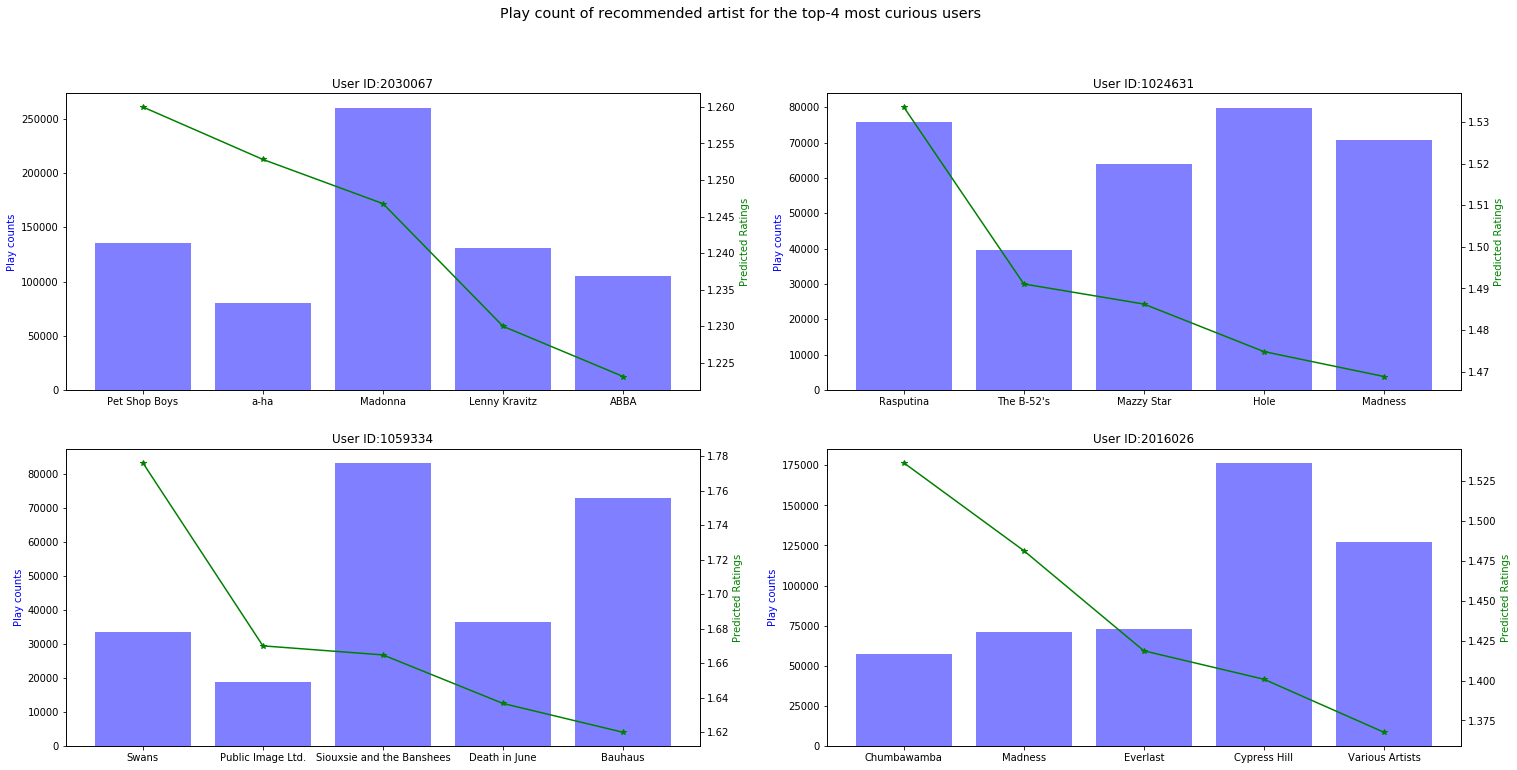

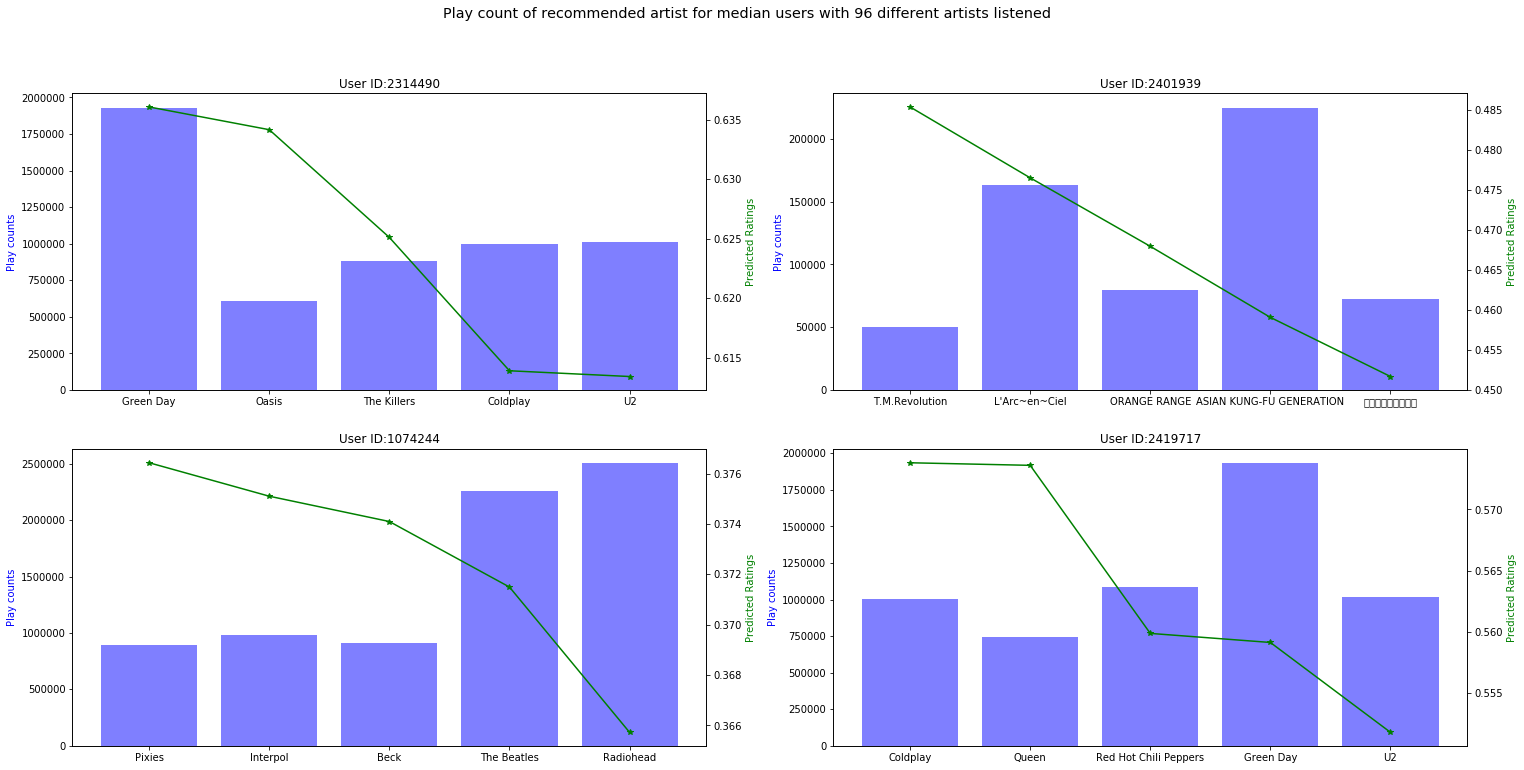

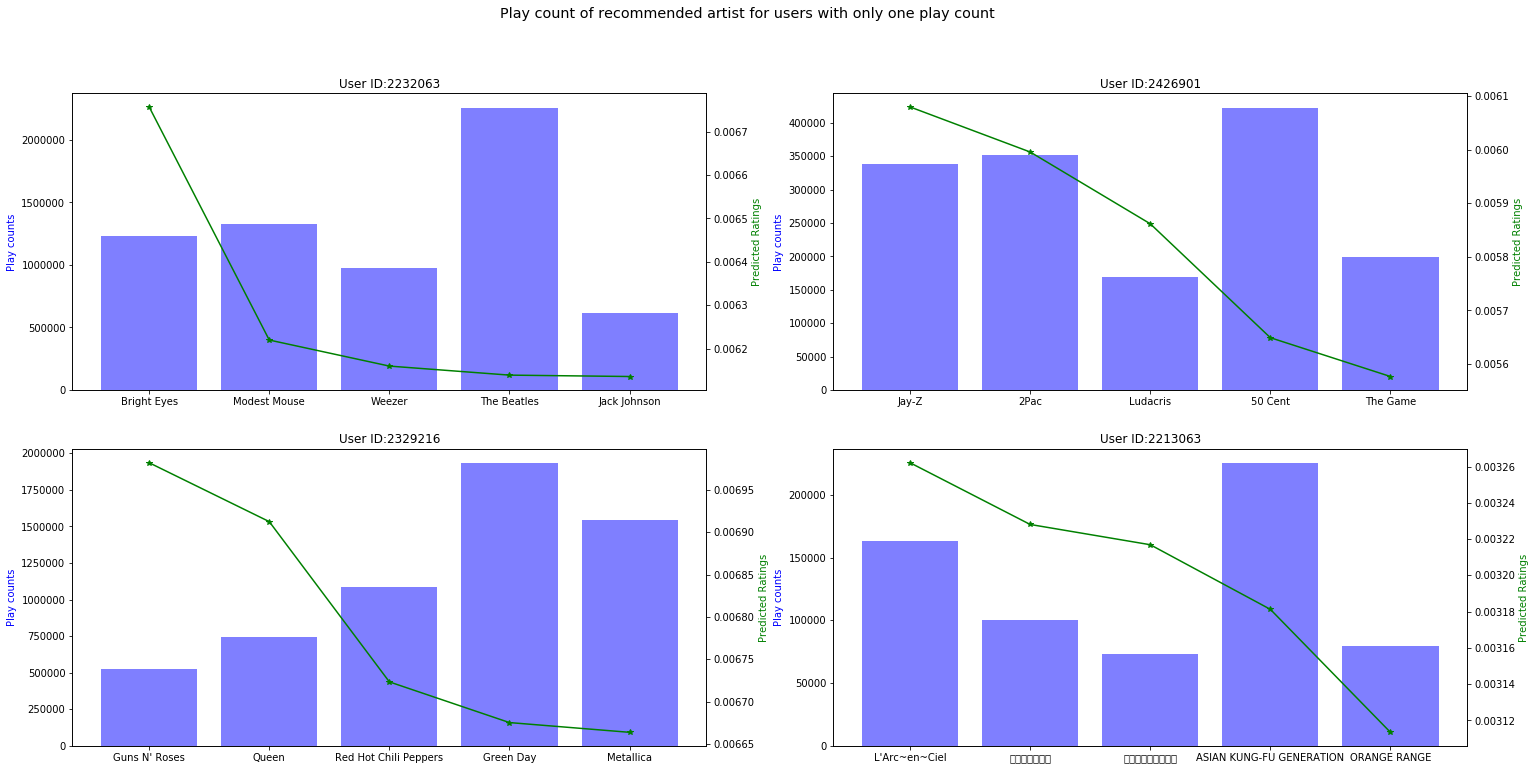

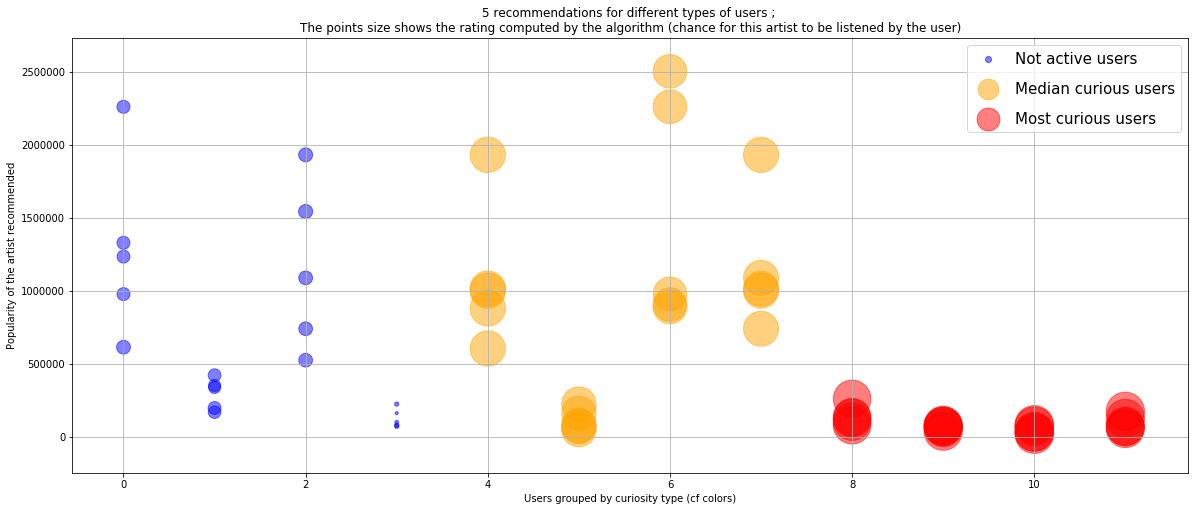

In [51]:
dictArtistNameRating, medianUsersDicNameRating, NonActiveUsersDicNameRating = plotRecommendationsStats(model)

Here is first plotted for several users as a bar charts the playcounts of the 5 artists recommended with the ratings as a curve on the same graph.

#### First 4 figures : most curious users

* Here is plotted the different play counts for the recommended artists for the 4 most curious Users.
* One can see that they seem to be personalized as all recommendations are different.
* The rating seems to not be correlated with the popularity of the artists recommended. As a curious user has already listened to a lot of artists, maybe he has also already listened to popular artists that correspond to his taste and can't be recommended to him.

#### Second 4 figures : median curious users (96 distinct listened)

* Same comment for the correlation between recommendation and popularity.
* The mean rating given by the algorithm has decreased a lot (approximately divided by 3). It could be because these users are less curious (we have less information about their taste) and have less playcounts, so we expect them to listen to recommendation a lower number of times than the most curious users.

#### Third 4 figures : least curious and active users (only 1 playCount)

* Same comment for the correlation between recommendation and popularity.
* The mean rating given by the algorithm has also decreased a lot (approximately divided by 100 comparing to the median curious users). They have listened to only one single song so they have listened to only one single artist. We have only a tiny hint about their taste , only 1 playCount is all the information we have. To make recommendations with only one known playCount is risky, we'll unlikely give a good recommendation, that's why the rating is so low compared to the previous ones.
* As we saw while cleaning the data, they are extreme but numerous , they need be taken into account by the model and may give hinsight about the model behaviours. Good recomendations for thoses users will increase the retention rate of the platform.
* The recommendation and its quality depends a lot on the type of the single artist listened by the user. If the artist is popular, you can compare it to other users taste and find a recommendation. If the artist has been listened by only a small number of people (in the worst case scenario, only by this user), it's really difficult to relate this information to other users tastes and so, to give a good recommendation with good ratings.

#### Fourth plot : Scatter plot: popularity, ratings and groups of users 

* The x-axis is the different users grouped by curiosity (same groups as the previous plots) with 4 users for each group defined by their color. The y-axis is the popularity of the recommendation given, and the size of the bubble is related to the rating given by the algorithm. In order to see something on the plot, size of bubbles have been represented in a log scale.
* We can see the same differences as above between the 3 groups. The ratings given by the model for the suggested recommendations seems to increase with the curiosity of the user concerned. It would be interesting to see more precisely the evolution of the rating.
* The quality of the recommendation seems to vary a lot when we have poor information about the user taste, such as for the least curious users. We can have some quite good rating with popular artists or bad rating for not at all popular ones. It depends a lot on the artist associated with the only playcount of the user.
* For the median users, the recommendations seems to recommendate popular and less popular. We have information about their taste which can lead to wise recommendations, independant from artists popularity.
* For the most active users, the ratings of recommendations are higher than for other users. A possible explanation has already been given in the comment of the first plot. The popularity of their recommendation seems to not be as high as for other groups of users. It could be explained by their curiosity, and our algorithm: in our method, since we consider that each artist they have already listened to, is rated with a number of playCounts, we don't recommend them, they already have a rating. Maybe they have already listened to all recommendations that could be done and that are popular, that could explain the lack of popular artists in the recommendations of curious users. The model may also have pinpointed the taste of the curious users and therefore recommended not pop-artists but more on-the-edge artists that corresponds to their taste.

Wordcloud of recommended artists size proportionnal to rating


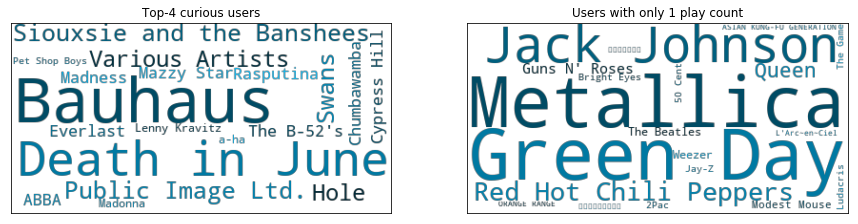

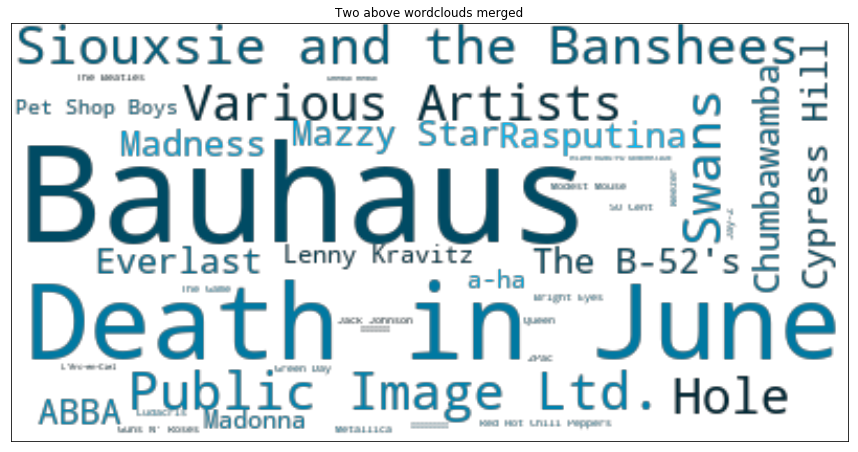

In [55]:
from wordcloud import WordCloud,get_single_color_func #External plugin "pip install wordcloud" to download
color_func1 = get_single_color_func('deepskyblue')

fig = plt.figure(figsize=(15,10))

print(r'Wordcloud of recommended artists size proportionnal to rating')

plt.subplot(121)
wc = WordCloud(background_color=None,mode="RGBA",max_words=1000,random_state=1).generate_from_frequencies(dictArtistNameRating)
plt.imshow(wc.recolor(color_func=color_func1, random_state=3),interpolation="bilinear")
plt.xticks([])
plt.yticks([])
plt.title("Top-4 curious users")


plt.subplot(122)
wc = WordCloud(background_color=None,mode="RGBA",max_words=1000,random_state=1).generate_from_frequencies(NonActiveUsersDicNameRating)
plt.imshow(wc.recolor(color_func=color_func1, random_state=3),interpolation="bilinear")
plt.xticks([])
plt.yticks([])
plt.title("Users with only 1 play count")

plt.figure(figsize=(15,10))
wc = WordCloud(background_color=None,mode="RGBA",max_words=1000,random_state=1).generate_from_frequencies({**dictArtistNameRating,**NonActiveUsersDicNameRating})
plt.imshow(wc.recolor(color_func=color_func1, random_state=3),interpolation="bilinear")
plt.xticks([])
plt.yticks([])
plt.title("Two above wordclouds merged")

plt.show()

* The wordcloud is useful to appreciate the difference of popularity or rating between different artists. Wordcloud is a way to effiently print words and meaning through the size of words.
* We chose to associate the size of the words to the rating of recommendations. We have plotted the wordcloud for the least and the most curious users, and then the merged wordcloud to compare the ratings.
* We see that the merged wordcloud is approximately the same as the one of the most active users. The ratings of their recommendations is really bigger as we've seen above. They are expected to listen a lot to the recommendations suggested to them. The only difference in the wordcloud is that we've add a lot of tiny words in the holes. And these words are simply the artists recommended for the least curious users. Even the best recommendation for the least active users, has a really low rating compared to the ratings of the most curious users.

In [56]:
def oneUserID(curiosity):
    """
    Returns a userID that correspond to the given curiosity.
    :param int curiosity: Number of different artists listened by a user.
    :return int userID: One userID that has this curiosity in the clean dataset.
    """
    processStep = dfNewUserCuriosity[dfNewUserCuriosity['count']==curiosity].take(1)
    if len(processStep)==0 : return None
    else : return processStep[0][0]

In [58]:
curiosities = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200,220,240,260,280,300,320,340,360,380,400,420,440,460,480,500,525,550,575,600,625,650,675,700,750,800,850,900,950,1000,1050,1100,1150,1200,1250,1300,1400,1500,1600,1699,2020,2404,2759,3328,3790,4005,4090,4411,4690,4734,4822,5773,5839,6125,6735]
ratingsList = []

for curio in curiosities :
    recommendationID, recommendationNameRating = getRecommendations(oneUserID(curio), 5, model)
    ratingToAdd = np.mean([t[1] for t in  recommendationNameRating])
    ratingsList.append(ratingToAdd)

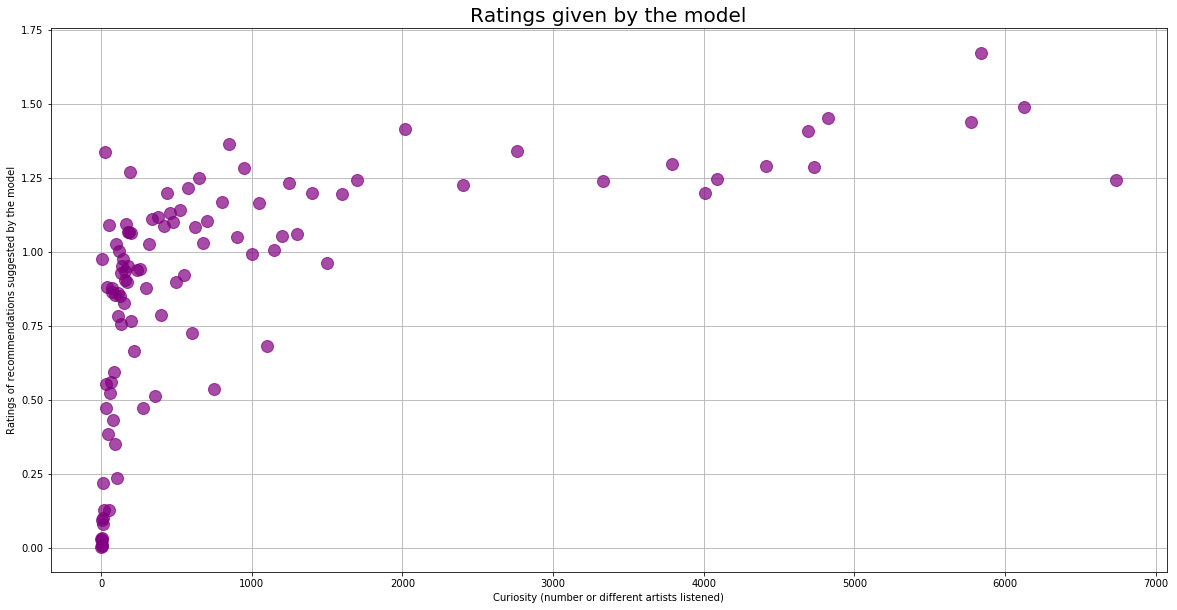

In [162]:
plt.figure(figsize=(20,10))
plt.plot(curiosities,ratingsList,color="purple",marker='o',markersize=12,ls=' ',alpha=0.7)
plt.grid('on')
plt.title("Ratings given by the model", fontsize="20")
plt.xlabel("Curiosity (number or different artists listened)")
plt.ylabel("Ratings of recommendations suggested by the model")
plt.show()

* The plot above shows the ratings given by the model for the recommendations suggested with respect to the curiosity of the user. For each curiosity, a random user is chosen, 5 recommendations are suggested, the rating plotted is in fact the mean of the ratings given for recommendations.
* We note that the rating seems to increase with the curiosity of the user. The deviation in the rating is higher with a low curiosity. Even for a median user with a curiosity of 96, it's possible to have pretty good ratings or bad ones. By chance, some users with poor curiosity can have ratings that reach approximately the same level as the level of the most curious users.
* From a curiosity of approximately 1500 distinct artists, the model seems to give more stable ratings, because the taste of the user is better known.

In [60]:
def unpersist(model):
    model.userFeatures().unpersist()
    model.productFeatures().unpersist()

# uncache data and model when they are no longer used  
unpersist(model)

## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as "artists the user has listened to", and the recommender system has already received all of this information as input. It could trivially return the users previously-listened artists as top recommendations and score perfectly. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can hide some of the artist play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
<div class="alert alert-info">
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:
<ul>
<li>`rank`=10</li>
<li>`iterations`=5</li>
<li>`lambda_`=0.01</li>
<li>`alpha`=1.0</li>
</ul>
</div>

In [61]:
trainData, cvData = allData.randomSplit([0.9,0.1])
trainData.cache()
cvData.cache()

PythonRDD[3045] at RDD at PythonRDD.scala:48

In [62]:
t0 = time()
model = ALS.trainImplicit(trainData, rank=10, iterations=5, lambda_=0.01, alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 85.295356 secs


#### Area under the ROC curve: a function to compute it

In [63]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [64]:
from random import randint

# Depend on the number of item in userIDAndPosItemIDs,
# create a set of "negative" products for each user. These are randomly chosen
# from among all of the other items, excluding those that are "positive" for the user.
# NOTE 1: mapPartitions operates on many (user,positive-items) pairs at once
# NOTE 2: flatMap breaks the collections above down into one big set of tuples
def xtractNegative(userIDAndPosItemIDs):
    def pickEnoughNegatives(line):
        userID = line[0]
        posItemIDSet = set(line[1])
        #posItemIDSet = line[1]
        negative = []
        allItemIDs = bAllItemIDs.value
        # Keep about as many negative examples per user as positive. Duplicates are OK.
        i = 0
        while (i < len(allItemIDs) and len(negative) < len(posItemIDSet)):
            itemID = allItemIDs[randint(0,len(allItemIDs)-1)]
            if itemID not in posItemIDSet:
                negative.append(itemID)
            i += 1
        
        # Result is a collection of (user,negative-item) tuples
        return map(lambda itemID: (userID, itemID), negative)

    # Init an RNG and the item IDs set once for partition
    # allItemIDs = bAllItemIDs.value
    return map(pickEnoughNegatives, userIDAndPosItemIDs)

def ratioOfCorrectRanks(positiveRatings, negativeRatings):
    
    # find number elements in arr that has index >= start and has value smaller than x
    # arr is a sorted array
    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
    
    ## AUC may be viewed as the probability that a random positive item scores
    ## higher than a random negative one. Here the proportion of all positive-negative
    ## pairs that are correctly ranked is computed. The result is equal to the AUC metric.
    correct = 0 ## L
    total = 0 ## L
    
    # sorting positiveRatings array needs more cost
    #positiveRatings = np.array(map(lambda x: x.rating, positiveRatings))

    negativeRatings = list(map(lambda x:x.rating, negativeRatings))
    
    #np.sort(positiveRatings)
    negativeRatings.sort()# = np.sort(negativeRatings)
    total = len(positiveRatings)*len(negativeRatings)
    
    for positive in positiveRatings:
        # Count the correctly-ranked pairs
        correct += findNumElementsSmallerThan(negativeRatings, positive.rating)
        
    ## Return AUC: fraction of pairs ranked correctly
    return float(correct) / total

def calculateAUC(positiveData, bAllItemIDs, predictFunction):
    # Take held-out data as the "positive", and map to tuples
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    # Make predictions for each of them, including a numeric score, and gather by user
    positivePredictions = predictFunction(positiveUserProducts).groupBy(lambda r: r.user)
    
    # Create a set of "negative" products for each user. These are randomly chosen 
    # from among all of the other items, excluding those that are "positive" for the user. 
    negativeUserProducts = positiveUserProducts.groupByKey().mapPartitions(xtractNegative).flatMap(lambda x: x)
    # Make predictions on the rest
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)
    
    return (
            positivePredictions.join(negativePredictions)
                .values()
                .map(
                    lambda positive_negativeRatings: ratioOfCorrectRanks(positive_negativeRatings[0], positive_negativeRatings[1])
                )
                .mean()
            )

####  Question 9.2
<div class="alert alert-info">
Using part `cvData` and function `calculateAUC` to compute the AUC of the trained model.
</div>

In [65]:
t0 = time()
auc = calculateAUC(cvData, bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))

auc= 0.9643364792077651
finish in 58.019971 seconds


* We use the validation data to calculate the AUC. We obtain a pretty good value that says with have approximately 96% of chance to a good recommendation rather than a bad one.

#### Question 9.3
<div class="alert alert-info">
Now we have the UAC of our model, it’s helpful to benchmark this against a simpler approach. For example, consider recommending the globally most-played artists to every user. This is not personalized, but is simple and may be effective.   
<ul></ul>
Implement this simple popularity-based prediction algorithm, evaluate its AUC score, and compare to the results achieved by the more sophisticated ALS algorithm.
</div>

In [66]:
#Equivalent to select(["artistID","playCount"]).groupBy("artistID").sum("playCount")
bListenCount = sc.broadcast(trainData.map(lambda r: (r[1], r[2])).reduceByKey(lambda x,y: x+y).collectAsMap())
def predictMostListened(allData):
    """ Returns a list in a RDD format of Rating objects: (userID,artistID,artistIDPopularity)
        Therefore the predicted rating is independant from the user tase. """
    return allData.map(lambda r: Rating(r[0], r[1], bListenCount.value.get(r[1], 0.0)))

In [67]:
auc = calculateAUC(cvData, bAllItemIDs, predictMostListened)
print("Not personalized recommendation system AUC:",auc)

Not personalized recommendation system AUC: 0.9374080545225423


* Here we simply have an algorithm that gives recommendation thanks to the popularity of the artists. The rating returned is the popularity of the artist. It's really a simple model, that is not personalized for the user at all.
* But a popular artist has generally more chances to be listened than another one, because the user could remember he has already listened to this music on the radio, and so continue to listen to it.
* The environment has a good impact on wath people are listening. In order to know the same songs as your friends, a user can tend to listen popular songs. That's why, even if it's not really personalized to the user tastes, it can give a quite good recommendation to the user. The AUC is not so bad for the simplicity of the model. For an application whose goal could be to save computation time, they could use this type of algorithm. For an application that want to have the more activity it's possible to have for their user, and give them the best personalized recommendations, disitnguishing the recommendation service from the other conccurent application, they have better using a more complex and optimized algorithm.

## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given parameters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLLIB, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
<div class="alert alert-info">
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.
</div>

In [68]:
evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit(trainData, rank=rank, iterations=5, lambda_=lambda_, alpha=alpha)
            
            auc = calculateAUC(cvData, bAllItemIDs, model.predictAll)
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)

Train model with rank=10 lambda_=1.000000 alpha=1.000000
Train model with rank=10 lambda_=1.000000 alpha=40.000000
Train model with rank=10 lambda_=0.000100 alpha=1.000000
Train model with rank=10 lambda_=0.000100 alpha=40.000000
Train model with rank=50 lambda_=1.000000 alpha=1.000000
Train model with rank=50 lambda_=1.000000 alpha=40.000000
Train model with rank=50 lambda_=0.000100 alpha=1.000000
Train model with rank=50 lambda_=0.000100 alpha=40.000000


In [69]:
evaluations.sort(key = lambda x: -x[1])
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist()

                    0         1
0     (50, 1.0, 40.0)  0.976252
1     (10, 1.0, 40.0)  0.976157
2  (50, 0.0001, 40.0)  0.974895
3  (10, 0.0001, 40.0)  0.974711
4      (10, 1.0, 1.0)  0.970027
5      (50, 1.0, 1.0)  0.966489
6   (10, 0.0001, 1.0)  0.965961
7   (50, 0.0001, 1.0)  0.953356


PythonRDD[3045] at RDD at PythonRDD.scala:48

* Here we train the model with different parameters that can have 2 different values (it's not really precise... but computation time is huge to train the model, so we will only have an approximation of the best AUC on validation data.
* Validation data is always the same, allData has been split in trainData and cvData at the beginning. To improve this method, we could cross-validation with the k-folds method, splitting randomly the allData each time, in order to avoid any overfitting problems...

#### Question 10.2 
<div class="alert alert-info">
Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-5 artist names recommendated for user `2093760`.
</div>

In [70]:
modelOpti = ALS.trainImplicit(trainData, rank=50, iterations=5, lambda_=1.0, alpha=40.0)
allData.unpersist()

userID = 2093760
recommendations = model.recommendProducts(userID, 5)

recommendedProductIDs = set(recommendations)

recList = artistByID.filter(artistNames).values().collect()
print(recList)

unpersist(model)

['50 Cent', 'Snoop Dogg', 'Ludacris', '2Pac', 'The Game']


* As one can see, the top-5 recommendations are the same as a whole.

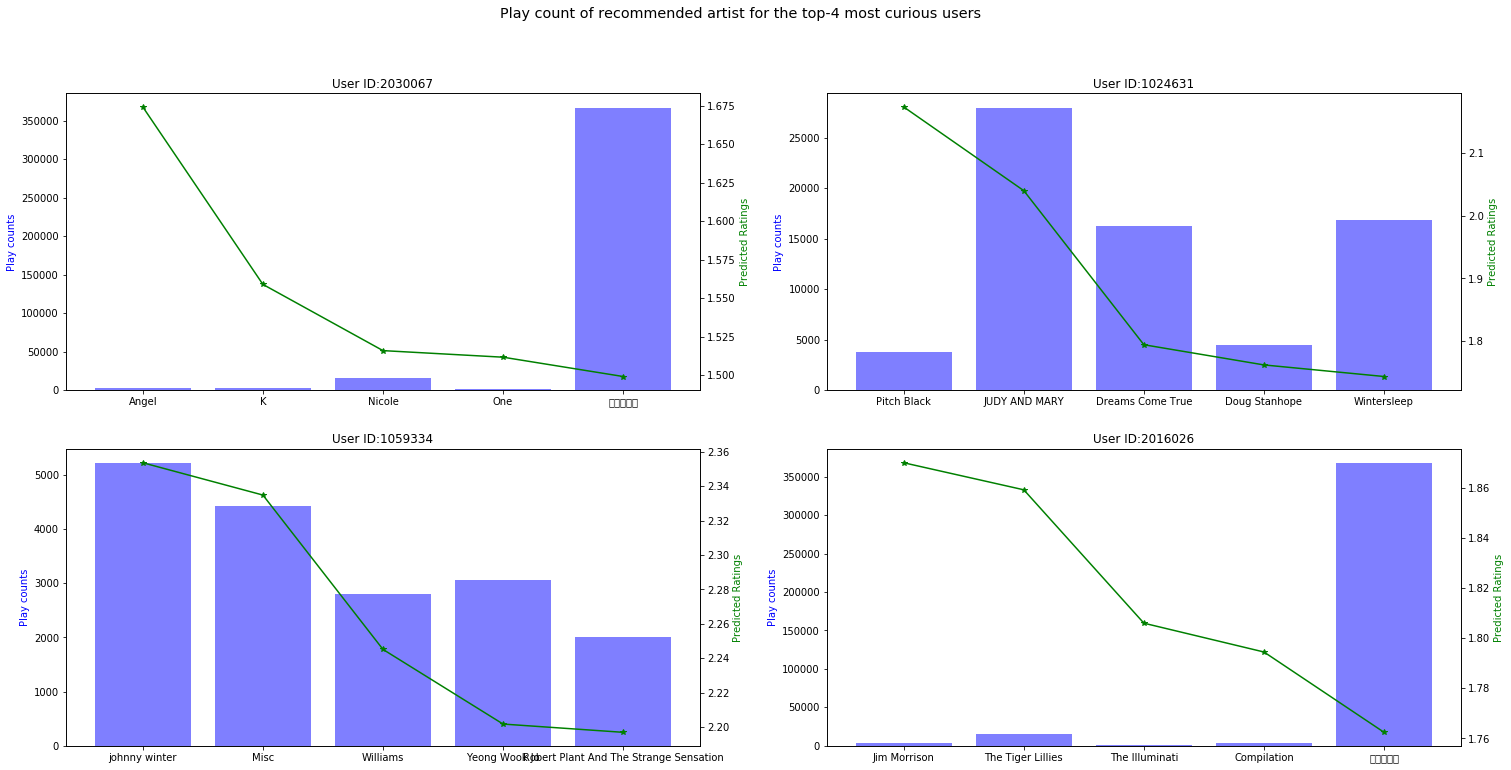

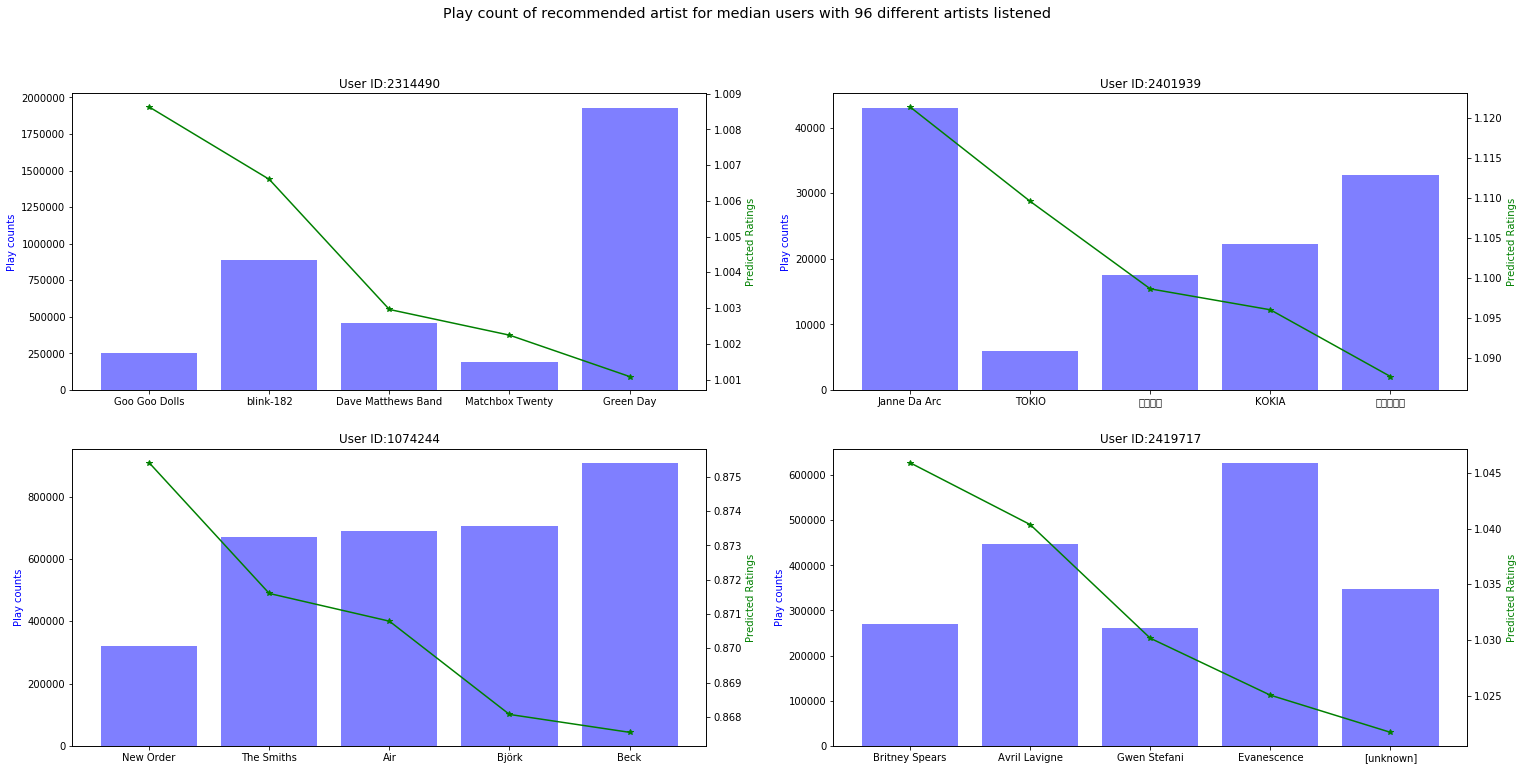

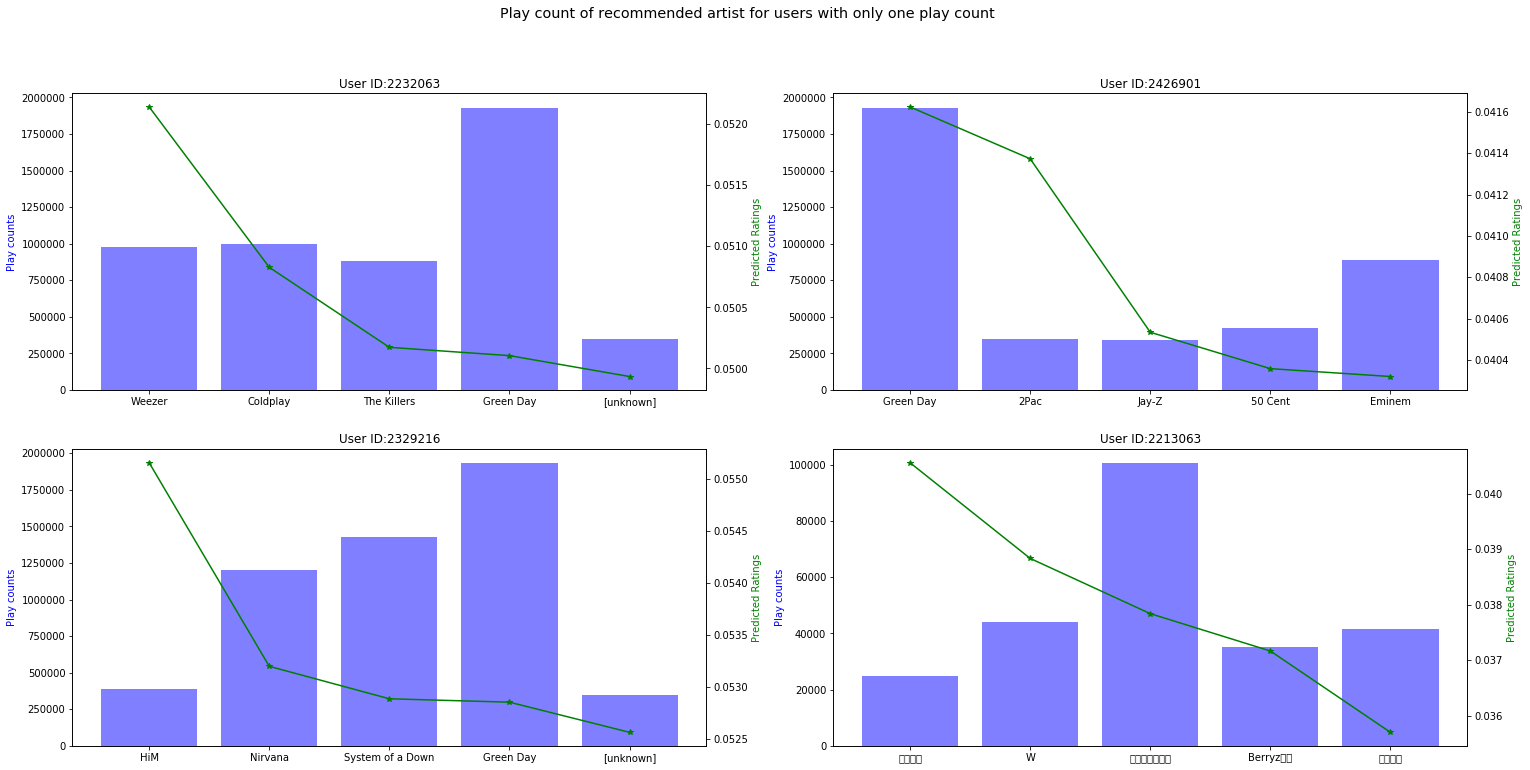

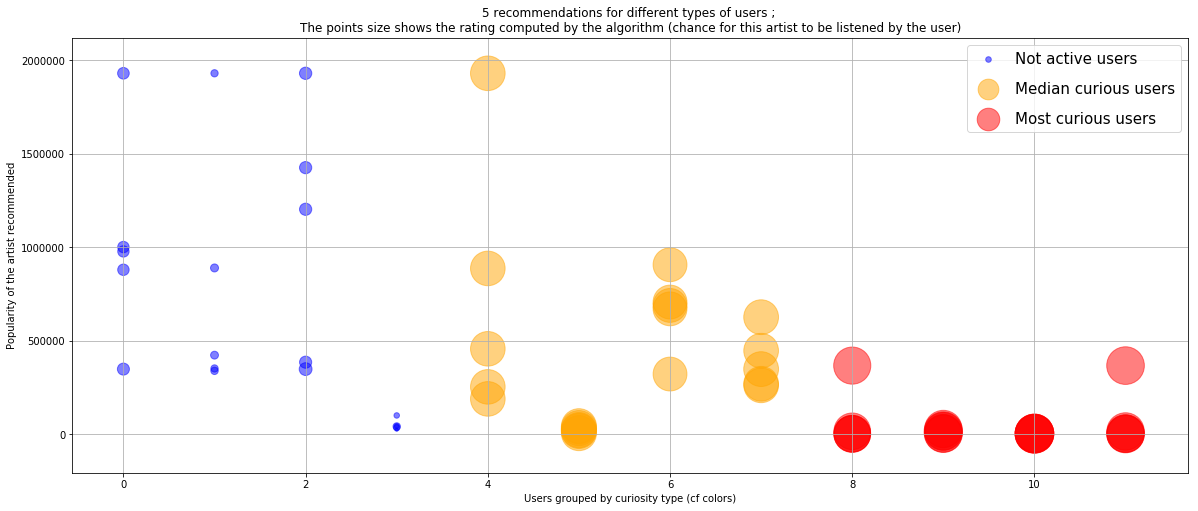

In [72]:
dictArtistNameRating, medianUsersDicNameRating, NonActiveUsersDicNameRating = plotRecommendationsStats(modelOpti)

* To better outline the benefit of the cross-validation and the benchmark, let's compare the statistics of recommendations for the users.
* To do that, the figures above bhave been generated through the same function but with the optimised model. Let's study the differences.

#### Recommendation Bar plots & Scatter Plot

* First observation: all recommendations are different from the ones with the first model we used.
* There is the same kind of trend: the more curious, the higher the recommendations ratings.
* BUT, for every group of users, if you compare the ratings with the first model with those, you can see that ratings are higher with this model.  


In [73]:
curiosities = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200,220,240,260,280,300,320,340,360,380,400,420,440,460,480,500,525,550,575,600,625,650,675,700,750,800,850,900,950,1000,1050,1100,1150,1200,1250,1300,1400,1500,1600,1699,2020,2404,2759,3328,3790,4005,4090,4411,4690,4734,4822,5773,5839,6125,6735]
ratingsListOpti = []

for curio in curiosities :
    recommendationID, recommendationNameRating = getRecommendations(oneUserID(curio), 5, modelOpti)
    ratingToAdd = np.mean([t[1] for t in  recommendationNameRating])
    ratingsListOpti.append(ratingToAdd)

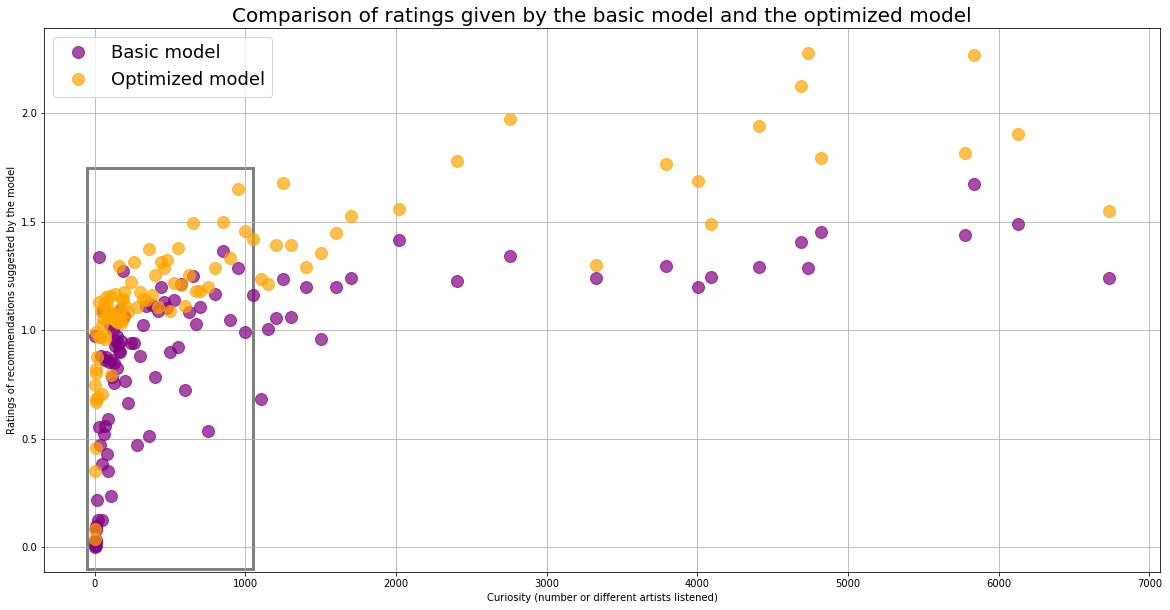

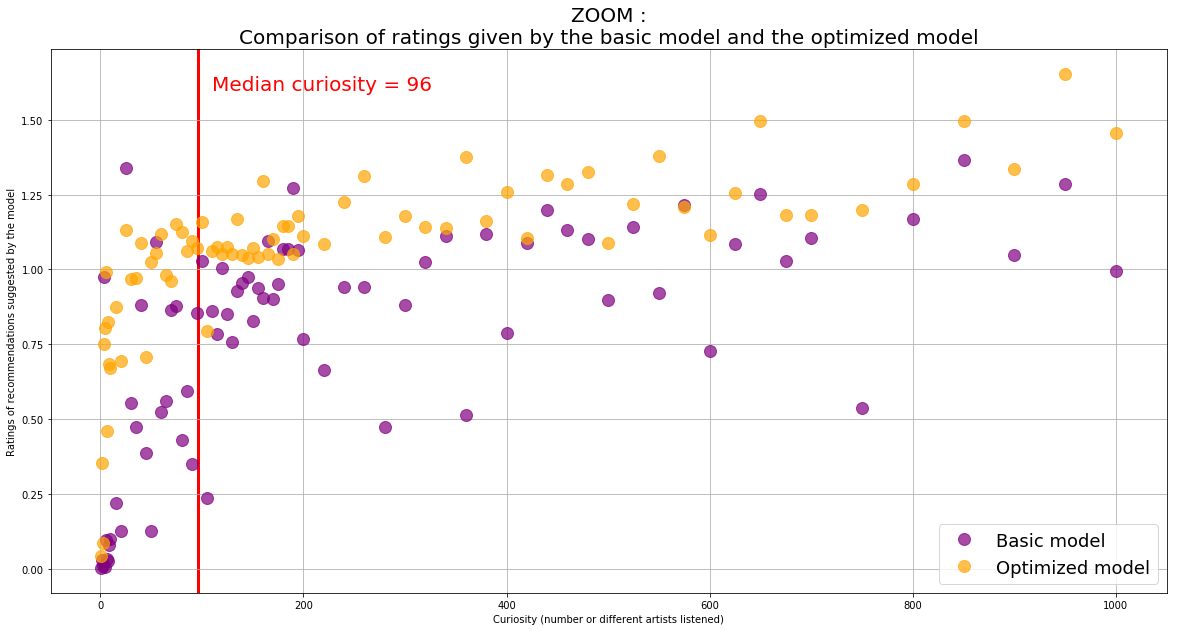

In [161]:
plt.figure(figsize=(20,10))
currAx = plt.gca()
plt.plot(curiosities,ratingsList,color="purple",marker='o',markersize=12,ls=' ',alpha=0.7)
plt.plot(curiosities,ratingsListOpti,color="orange",marker='o',markersize=12,ls=' ',alpha=0.7)
plt.grid('on')
currAx.add_patch(pat.Rectangle((-50,-0.1),1100,1.85,color="grey",lw=3,fill=False))
plt.title("Comparison of ratings given by the basic model and the optimized model", fontsize="20")
plt.legend(("Basic model","Optimized model"),fontsize=18)
plt.xlabel("Curiosity (number or different artists listened)")
plt.ylabel("Ratings of recommendations suggested by the model")
plt.show()

plt.figure(figsize=(20,10))
untilIndex = 77
currAxZoom = plt.gca()
plt.plot(curiosities[0:untilIndex],ratingsList[0:untilIndex],color="purple",marker='o',markersize=12,ls=' ',alpha=0.7)
plt.plot(curiosities[0:untilIndex],ratingsListOpti[0:untilIndex],color="orange",marker='o',markersize=12,ls=' ',alpha=0.7)
plt.grid('on')
currAxZoom.add_patch(pat.Rectangle((96,-0.1),0.1,1.85,color="red",lw=3,fill=False))
plt.title("ZOOM :\nComparison of ratings given by the basic model and the optimized model", fontsize="20")
plt.legend(("Basic model","Optimized model"),fontsize=18)
plt.xlabel("Curiosity (number or different artists listened)")
plt.ylabel("Ratings of recommendations suggested by the model")
plt.text(110,1.6,s="Median curiosity = 96", fontsize=20, color="red")
plt.show()

* In order to compare the basic model and the optimized one, we have plotted the ratings returned with respect to the curiosity of users for both models. Then we zoom in for low curiosities that represent the vast majority of users.
* As one can see, the optimized model seems to return higher ratings than the previous one (indeed, the AUC of the optimized model is higher).
* The important fact to note is that the deviation has decreased for users with low curiosity. A median user have more chances to get ratings between [0.75,1.25] whereas with the basic model it was between [0.25,1.25]. The chance to have good ratings for a median user has increased.
* The optimized model seems to give more stable and higher ratings than the basic one for users with low curiosity. Therefore the ratings of recommendations of a major part of users are globally better.
* Even if increasing AUC from 0.96433 to 0.97625 (about 1%) doesn't seem at first to be significant, a better recommendation system can totally change the recommendations given to the users and we can see how much it's important for the quality of recommendations given. Give good recommendations also means giving good recommendations for most users and not only for the ones we know the best, because all users are important, especially the user that represents the median user of the application.

# Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system on SPARK using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.

# References

- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)